# Causal Impact of Incentives on Birth Rate

After reading and discussing two *Financial Times* articles with a friend, I became interested in the effectiveness of incentives aimed at increasing birthrates.  

### **Key Takeaways from the Articles**  
- Developed countries are experiencing a **sharp decline in birthrates**.  
- The majority of countries now have a **fertility rate below the population replacement rate** ([source](https://en.wikipedia.org/wiki/List_of_countries_by_total_fertility_rate#Country_ranking_by_international_organizations)).  
- This decline is expected to **lower living standards** for younger generations as they reach retirement age.  
- Without a significant economic shift, there may not be enough workers to sustain economic growth.  

### **Our Discussion**  
My friend and I explored potential solutions, particularly the role of **artificial intelligence (AI)** in mitigating workforce shortages. We shared the assumption that **reversing the declining birthrate trend is extremely difficult, if not impossible**.  

Some key points from our discussion:  
- Once a country reaches a certain level of **development, having children may become a lower priority**.  
- **Japan serves as a strong case study** since it resists immigration and faces a rapidly aging population.  
- Even in countries that welcome immigration, if global birthrate declines persist, there may **eventually be too few people to fill workforce gaps—even through immigration**.  
- The trend appears to be **universal, cutting across cultures and persisting despite government incentives**.  

### **The Central Question**  
Given that the articles argue governmental aid and incentives have had **limited success**, I wanted to investigate from a causal inference perspective:  
***Are these incentives actually making a difference?***

---

**Financial Times Articles:**

1. [Falling birth rates raise prospect of sharp decline in living standards
](https://www.ft.com/content/19cea1e0-4b8f-4623-bf6b-fe8af2acd3e5) 
2. [The baby gap: why governments can’t pay their way to higher birth rates](https://www.ft.com/content/2f4e8e43-ab36-4703-b168-0ab56a0a32bc)

In [80]:
import pandas as pd
import numpy as np
from graphviz import Digraph
import graphviz as gr
from IPython.display import Image
from dowhy import CausalModel
import dowhy.plotter
import matplotlib
import cvxpy as cp
from matplotlib import pyplot as plt
from matplotlib import font_manager
from matplotlib.font_manager import FontProperties
from cycler import cycler
from linearmodels import PanelOLS
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression, LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import statsmodels.api as sm
from linearmodels.panel import compare
from scipy import stats

### Causal Graph

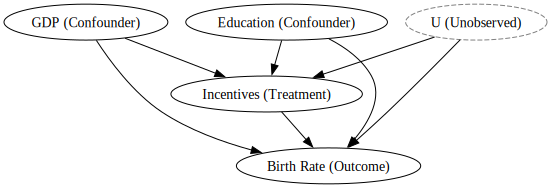

In [2]:
causal_graph = Digraph(name="Causal Graph", format="png", engine="dot")

causal_graph.node("Incentives", "Incentives (Treatment)")
causal_graph.node("BirthRate", "Birth Rate (Outcome)")
causal_graph.node("GDP", "GDP (Confounder)")
causal_graph.node("Education", "Education (Confounder)")
causal_graph.node("U", "U (Unobserved)", color="gray", style="dashed")

causal_graph.edges([
    ("Incentives", "BirthRate"),
    ("GDP", "Incentives"),
    ("GDP", "BirthRate"),
    ("Education", "Incentives"),
    ("Education", "BirthRate"),
    ("U", "Incentives"),
    ("U", "BirthRate")
])

causal_graph

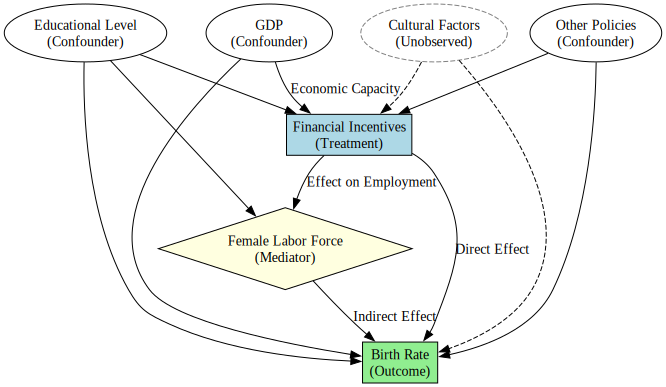

In [3]:
# Create a more detailed causal graph
from graphviz import Digraph

detailed_graph = Digraph(name="Detailed Causal Graph", format="png", engine="dot")

# Add nodes
detailed_graph.node("Incentives", "Financial Incentives\n(Treatment)", shape="box", style="filled", fillcolor="lightblue")
detailed_graph.node("BirthRate", "Birth Rate\n(Outcome)", shape="box", style="filled", fillcolor="lightgreen")
detailed_graph.node("GDP", "GDP\n(Confounder)", shape="oval")
detailed_graph.node("Education", "Educational Level\n(Confounder)", shape="oval")
detailed_graph.node("Labor", "Female Labor Force\n(Mediator)", shape="diamond", style="filled", fillcolor="lightyellow")
detailed_graph.node("Culture", "Cultural Factors\n(Unobserved)", shape="oval", style="dashed", color="gray")
detailed_graph.node("Policy", "Other Policies\n(Confounder)", shape="oval")

# Add edges
detailed_graph.edge("Incentives", "BirthRate", label="Direct Effect")
detailed_graph.edge("Incentives", "Labor", label="Effect on Employment")
detailed_graph.edge("Labor", "BirthRate", label="Indirect Effect")
detailed_graph.edge("GDP", "Incentives", label="Economic Capacity")
detailed_graph.edge("GDP", "BirthRate")
detailed_graph.edge("Education", "Incentives")
detailed_graph.edge("Education", "BirthRate")
detailed_graph.edge("Education", "Labor")
detailed_graph.edge("Culture", "BirthRate", style="dashed")
detailed_graph.edge("Culture", "Incentives", style="dashed")
detailed_graph.edge("Policy", "BirthRate")
detailed_graph.edge("Policy", "Incentives")

# Render graph
detailed_graph

### Load Data

In [32]:
pd_gdp = pd.read_csv("data/GDP/gdp.csv")

In [33]:
pd_gdp[9:14]
pd_gdp.drop(index=[9,10,11,12,13], inplace=True)
pd_gdp.drop(columns=["Series Code"], inplace=True)

In [34]:
df_fertility = pd.read_csv("data/fertilityRate/fertility.csv")

In [35]:
df_fertility.drop(index=[9,10,11,12,13], inplace=True)
df_fertility.drop(columns=["Series Code"], inplace=True)

In [36]:
df_edu = pd.read_csv('data/Education/edu.csv')

df_edu['Series Name'] = df_edu['Series Name'].str.strip()

target_series = [
    "Labor force, female (% of total labor force)",
    "Educational attainment, at least completed post-secondary, population 25+, female (%) (cumulative)",
    "Educational attainment, at least completed post-secondary, population 25+, total (%) (cumulative)",
    "Educational attainment, at least Bachelor's or equivalent, population 25+, female (%) (cumulative)",
    "Educational attainment, at least Bachelor's or equivalent, population 25+, total (%) (cumulative)"
]

# dictionary of DataFrames
dfs = {name: df_edu[df_edu['Series Name'] == name].copy() for name in target_series}

In [37]:
# Access individual DataFrames 
labor_female_df = dfs[target_series[0]]
labor_female_df.drop(columns=["Series Code"], inplace=True)

In [38]:
post_secondary_female_df = dfs[target_series[1]]
post_secondary_female_df.drop(columns=["Series Code"], inplace=True)

In [39]:
post_secondary_total_df = dfs[target_series[2]]
post_secondary_total_df.drop(columns=["Series Code"], inplace=True)

In [40]:
post_bachelor_female_df = dfs[target_series[3]]
post_bachelor_female_df.drop(columns=["Series Code"], inplace=True)

In [41]:
post_bachelor_total_df = dfs[target_series[4]]
post_bachelor_total_df.drop(columns=["Series Code"], inplace=True)

### Long Data

In [42]:
fertility_long = (
    df_fertility
    .melt(
        id_vars=['Country Name', 'Country Code', 'Series Name'],
        var_name='Year',
        value_name='Fertility_Rate'
    )
    # Extract year from strings like "1990 [YR1990]"
    .assign(Year=lambda x: x['Year'].str.extract(r'(\d{4})').astype(int))
    # .query("`Country Name` in ['Japan', 'Korea, Rep.', 'Sweden']")
)

In [43]:
gdp_long = (
    pd_gdp.melt(
        id_vars=['Country Name', 'Country Code', 'Series Name'],
        var_name='Year',
        value_name='GDP'
    ).assign(Year=lambda x: x['Year'].str.extract(r'(\d{4})').astype(int))
)

In [44]:
labor_female_long = (
    labor_female_df.melt(
        id_vars=['Country Name', 'Country Code', 'Series Name'],
        var_name='Year',
        value_name='Labor_Force_Female'
    ).assign(Year=lambda x: x['Year'].str.extract(r'(\d{4})').astype(int))
)

In [45]:
post_secondary_female_long = (
    post_secondary_female_df.melt(
        id_vars=['Country Name', 'Country Code', 'Series Name'],
        var_name='Year',
        value_name='Post_Secondary_Female'
    ).assign(Year=lambda x: x['Year'].str.extract(r'(\d{4})').astype(int))
)

In [46]:
post_secondary_total_long = (
    post_secondary_total_df.melt(
        id_vars=['Country Name', 'Country Code', 'Series Name'],
        var_name='Year',
        value_name='Post_Secondary_Total'
    ).assign(Year=lambda x: x['Year'].str.extract(r'(\d{4})').astype(int))
)

In [47]:
post_bachelor_female_long = (
    post_bachelor_female_df.melt(
        id_vars=['Country Name', 'Country Code', 'Series Name'],
        var_name='Year',
        value_name='Post_Bachelor_Female'
    ).assign(Year=lambda x: x['Year'].str.extract(r'(\d{4})').astype(int))
)

In [48]:
post_bachelor_total_long = (
    post_bachelor_total_df.melt(
        id_vars=['Country Name', 'Country Code', 'Series Name'],
        var_name='Year',
        value_name='Post_Bachelor_Total'
    ).assign(Year=lambda x: x['Year'].str.extract(r'(\d{4})').astype(int))
)

In [49]:
# remove Series to fix dupicate columns error
fertility_clean = fertility_long[['Country Name', 'Year', 'Fertility_Rate']]
gdp_clean = gdp_long[['Country Name', 'Year', 'GDP']]
post_secondary_clean = post_secondary_total_long[['Country Name', 'Year', 'Post_Secondary_Total']]
post_bachelor_clean = post_bachelor_total_long[['Country Name', 'Year', 'Post_Bachelor_Total']]
labor_female_clean = labor_female_long[['Country Name', 'Year', 'Labor_Force_Female']]

In [50]:
merged = (
    fertility_clean
    .merge(gdp_clean, on=['Country Name', 'Year'], how='inner')
    .merge(post_secondary_clean, on=['Country Name', 'Year'])
    .merge(post_bachelor_clean, on=['Country Name', 'Year'])
    .merge(labor_female_clean, on=['Country Name', 'Year'])
    .sort_values(['Country Name', 'Year'])
)
merged

,Country Name,Year,Fertility_Rate,GDP,Post_Secondary_Total,Post_Bachelor_Total,Labor_Force_Female
1,Denmark,1990,1.67,1.382177e+11,..,..,46.4031459405589
10,Denmark,1991,1.68,1.391805e+11,..,..,46.7138742741135
19,Denmark,1992,1.76,1.529665e+11,..,..,46.9062773288618
28,Denmark,1993,1.75,1.431113e+11,..,..,46.88246527298
37,Denmark,1994,1.81,1.560179e+11,..,..,45.8394823598453
...,...,...,...,...,...,...,...
261,Sweden,2019,1.71,5.321693e+11,40,25.0799999237061,47.4352661367012
270,Sweden,2020,1.67,5.451476e+11,49.8847312927246,32.5396308898926,47.1515158165803
279,Sweden,2021,1.67,6.371869e+11,49.3100547790527,32.6667137145996,47.2323542656069
288,Sweden,2022,1.52,5.798957e+11,50.8245239257812,33.6940689086914,47.167795771586


In [51]:
merged['Country Name'].unique()

array(['Denmark', 'Finland', 'Greece', 'Hong Kong SAR, China', 'Hungary',
       'Japan', 'Korea, Rep.', 'Russian Federation', 'Sweden'],
      dtype=object)

In [64]:
merged[merged['Country Name'] == 'Russian Federation']

,Country Name,Year,Fertility_Rate,GDP,Post_Secondary_Total,Post_Bachelor_Total,Labor_Force_Female
6,Russian Federation,1990,1.892,5.170144e+11,..,..,48.220942
15,Russian Federation,1991,1.732,5.179630e+11,..,..,48.080097
24,Russian Federation,1992,1.552,4.602906e+11,..,..,47.797966
33,Russian Federation,1993,1.385,4.350837e+11,..,..,47.546323
42,Russian Federation,1994,1.400,3.950773e+11,..,..,47.343440
51,Russian Federation,1995,1.337,3.955372e+11,..,..,47.300321
60,Russian Federation,1996,1.270,3.917249e+11,..,..,47.367544
69,Russian Federation,1997,1.218,4.049290e+11,..,..,47.503375
78,Russian Federation,1998,1.232,2.709555e+11,..,..,47.611859
87,Russian Federation,1999,1.157,1.959071e+11,..,..,48.219959


# Synthetic Control

In [241]:
# Function to perform synthetic control analysis
def synthetic_control_analysis(data, treated_country, policy_year, 
                              control_countries, outcome_var, 
                              predictor_vars, placebo_trials=100):
    """
    Perform synthetic control analysis with confidence intervals
    
    Parameters:
    data (DataFrame): Panel data with countries and years
    treated_country (str): Name of treated country
    policy_year (int): Year of policy introduction
    control_countries (list): List of potential control countries
    outcome_var (str): Outcome variable name
    predictor_vars (list): List of predictor variable names
    placebo_trials (int): Number of placebo trials for inference
    
    Returns:
    dict: Results including actual series, synthetic series, and confidence intervals
    """
    # Convert datatypes and handle NAs
    for var in [outcome_var] + predictor_vars:
        data[var] = pd.to_numeric(data[var], errors='coerce')
    
    # Filter data
    treated_data = data[data['Country Name'] == treated_country].copy()
    control_data = data[data['Country Name'].isin(control_countries)].copy()
    
    # Drop missing values
    treated_data = treated_data.dropna(subset=[outcome_var] + predictor_vars)
    control_data = control_data.dropna(subset=[outcome_var] + predictor_vars)
    
    # Split into pre and post treatment periods
    pre_treatment = treated_data[treated_data['Year'] < policy_year]
    post_treatment = treated_data[treated_data['Year'] >= policy_year]
    
    # Check if we have enough pre-treatment data
    if len(pre_treatment) < 5:
        print(f"Warning: Only {len(pre_treatment)} pre-treatment observations for {treated_country}")
    
    # Prepare control data for the pre-treatment period
    pre_control = control_data[control_data['Year'].isin(pre_treatment['Year'])]
    
    # Create matrices for synthetic control
    X_treated = pre_treatment[predictor_vars].values
    y_treated = pre_treatment[outcome_var].values
    
    # Group control data by country and year
    control_groups = []
    valid_control_countries = []
    
    for country, group in pre_control.groupby('Country Name'):
        # Check if we have data for all pre-treatment years
        if set(group['Year']) == set(pre_treatment['Year']):
            X_control = group[predictor_vars].values
            y_control = group[outcome_var].values
            control_groups.append((X_control, y_control, country))
            valid_control_countries.append(country)
    
    if not control_groups:
        return {"error": "No valid control countries with complete data"}
    
    # Create donor pool matrices
    X_combined = np.vstack([g[0] for g in control_groups])
    y_combined = np.concatenate([g[1] for g in control_groups])
    
    # Add country indicators for different intercepts
    country_indicators = np.zeros((X_combined.shape[0], len(control_groups)))
    row_idx = 0
    for i, (X, y, _) in enumerate(control_groups):
        rows = X.shape[0]
        country_indicators[row_idx:row_idx+rows, i] = 1
        row_idx += rows
    
    X_with_indicators = np.hstack([X_combined, country_indicators])
    
    # Fit model to find optimal weights
    lasso = LassoCV(cv=5, fit_intercept=True, max_iter=10000)
    lasso.fit(X_with_indicators, y_combined)
    
    # Extract country weights (from the country indicators part of coefficients)
    country_weights = lasso.coef_[-len(control_groups):]
    
    # Handle negative weights by setting them to zero and renormalizing
    country_weights = np.maximum(country_weights, 0)
    if sum(country_weights) > 0:
        normalized_weights = country_weights / sum(country_weights)
    else:
        # If all weights are zero, use equal weights
        normalized_weights = np.ones(len(control_groups)) / len(control_groups)
    
    print(f"\nSynthetic Control Weights for {treated_country}:")
    for country, weight in zip(valid_control_countries, normalized_weights):
        if weight > 0.01:  # Only show countries with non-negligible weights
            print(f"  {country}: {weight:.4f}")
    
    # Generate synthetic control series for all years
    all_years = sorted(list(set(treated_data['Year'])))
    synthetic_series = {}
    
    for year in all_years:
        # For each year, compute weighted average of control countries
        synthetic_value = 0
        weight_sum = 0
        
        for i, (_, _, country) in enumerate(control_groups):
            weight = normalized_weights[i]
            if weight <= 0.01:  # Skip negligible weights
                continue
                
            country_year = control_data[(control_data['Country Name'] == country) & 
                                        (control_data['Year'] == year)]
            
            if len(country_year) > 0 and not pd.isna(country_year[outcome_var].values[0]):
                synthetic_value += weight * country_year[outcome_var].values[0]
                weight_sum += weight
        
        if weight_sum > 0:
            synthetic_series[year] = synthetic_value / weight_sum
    
    # Calculate treatment effect (gap between actual and synthetic)
    gap_series = {}
    for year in synthetic_series.keys():
        actual_year = treated_data[treated_data['Year'] == year]
        if len(actual_year) > 0:
            gap_series[year] = actual_year[outcome_var].values[0] - synthetic_series[year]
    
    # Run placebo tests for inference
    placebo_gaps = {}
    
    # Only run placebo tests if we have enough control countries
    if len(valid_control_countries) >= 3:
        for i, placebo_country in enumerate(valid_control_countries):
            if i >= placebo_trials:
                break
                
            # Temporarily treat a control country as treated
            placebo_data = data[data['Country Name'] == placebo_country].copy()
            placebo_control = data[data['Country Name'].isin([c for c in valid_control_countries if c != placebo_country])].copy()
            
            # Repeat synthetic control process
            placebo_pre = placebo_data[placebo_data['Year'] < policy_year]
            placebo_post = placebo_data[placebo_data['Year'] >= policy_year]
            
            if len(placebo_pre) < 5:
                continue  # Skip if not enough pre-treatment data
                
            # Much simplified version for placebos to save computation
            placebo_synthetic = {}
            for year in all_years:
                # Simple average of other control countries for placebo synthetic
                controls_at_year = placebo_control[placebo_control['Year'] == year]
                if len(controls_at_year) > 0:
                    placebo_synthetic[year] = controls_at_year[outcome_var].mean()
            
            # Calculate placebo gaps
            placebo_gaps[placebo_country] = {}
            for year in placebo_synthetic.keys():
                placebo_at_year = placebo_data[placebo_data['Year'] == year]
                if len(placebo_at_year) > 0:
                    placebo_gaps[placebo_country][year] = placebo_at_year[outcome_var].values[0] - placebo_synthetic[year]
    
    # Calculate confidence intervals from placebo distribution
    confidence_intervals = {}
    for year in gap_series.keys():
        if len(placebo_gaps) >= 20:  # Only calculate if we have sufficient placebos
            placebo_values = [gaps.get(year, 0) for country, gaps in placebo_gaps.items()]
            # 95% confidence interval
            lower_ci = np.percentile(placebo_values, 2.5)
            upper_ci = np.percentile(placebo_values, 97.5)
            confidence_intervals[year] = (lower_ci, upper_ci)
        else:
            # Approximate confidence intervals using pre-treatment fit
            pre_years = [y for y in pre_treatment['Year'] if y in synthetic_series]
            pre_gaps = [gap_series[y] for y in pre_years]
            if pre_gaps:
                sd = np.std(pre_gaps)
                confidence_intervals[year] = (-1.96 * sd, 1.96 * sd)
            else:
                confidence_intervals[year] = (-0.2, 0.2)  # Default if no data
    
    # Calculate RMSPE (root mean square prediction error) for pre-treatment fit
    pre_years = [y for y in pre_treatment['Year'] if y in synthetic_series]
    pre_gaps = [gap_series[y] for y in pre_years]
    rmspe = np.sqrt(np.mean(np.square(pre_gaps))) if pre_gaps else None
    
    # Calculate average treatment effect on the treated (ATT)
    post_years = [y for y in post_treatment['Year'] if y in synthetic_series]
    post_gaps = [gap_series[y] for y in post_years]
    att = np.mean(post_gaps) if post_gaps else None
    
    # Prepare results
    results = {
        "country": treated_country,
        "policy_year": policy_year,
        "actual_series": {year: treated_data[treated_data['Year'] == year][outcome_var].values[0] 
                         for year in all_years if year in treated_data['Year'].values},
        "synthetic_series": synthetic_series,
        "gap_series": gap_series,
        "confidence_intervals": confidence_intervals,
        "att": att,
        "rmspe": rmspe,
        "weights": {country: weight for country, weight in zip(valid_control_countries, normalized_weights)}
    }
    
    return results

In [242]:
def plot_synthetic_control_results(results, title=None):
    """
    Plot synthetic control results with confidence intervals
    
    Parameters:
    results (dict): Results from synthetic_control_analysis
    title (str): Title for the plot
    """
    if "error" in results:
        print(f"Error: {results['error']}")
        return
        
    plt.figure(figsize=(12, 8), dpi=300)
    
    # Extract data
    country = results["country"]
    policy_year = results["policy_year"]
    actual_series = results["actual_series"]
    synthetic_series = results["synthetic_series"]
    gap_series = results["gap_series"]
    confidence_intervals = results["confidence_intervals"]
    att = results["att"]
    rmspe = results["rmspe"]
    
    # Plot actual vs synthetic
    years = sorted(list(set(actual_series.keys()) | set(synthetic_series.keys())))
    
    actual_years = sorted(actual_series.keys())
    actual_values = [actual_series[y] for y in actual_years]
    
    synthetic_years = sorted(synthetic_series.keys())
    synthetic_values = [synthetic_series[y] for y in synthetic_years]
    
    # Panel A: Actual vs Synthetic
    plt.subplot(2, 1, 1)
    plt.plot(actual_years, actual_values, 'b-', linewidth=2, label=f'Actual {country}')
    plt.plot(synthetic_years, synthetic_values, 'r--', linewidth=2, label='Synthetic Control')
    plt.axvline(x=policy_year, color='green', linestyle='--', label='Policy Implementation')
    
    plt.title(title or f'Synthetic Control Analysis: {country}')
    plt.ylabel('Fertility Rate')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    
    # Add annotations
    if att is not None and rmspe is not None:
        plt.annotate(f"Avg. Treatment Effect: {att:.3f}\nPre-treatment RMSPE: {rmspe:.3f}", 
                    xy=(0.05, 0.05), xycoords='axes fraction',
                    bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8))
    
    # Panel B: Gap with confidence intervals
    plt.subplot(2, 1, 2)
    
    gap_years = sorted(gap_series.keys())
    gap_values = [gap_series[y] for y in gap_years]
    
    plt.plot(gap_years, gap_values, 'b-', linewidth=2, label='Effect (Actual - Synthetic)')
    plt.axvline(x=policy_year, color='green', linestyle='--', label='Policy Implementation')
    plt.axhline(y=0, color='red', linestyle='-', alpha=0.3)
    
    # Add confidence intervals
    ci_years = sorted(confidence_intervals.keys())
    lower_ci = [confidence_intervals[y][0] for y in ci_years]
    upper_ci = [confidence_intervals[y][1] for y in ci_years]
    
    plt.fill_between(ci_years, lower_ci, upper_ci, color='gray', alpha=0.2, label='95% Confidence Interval')
    
    plt.title('Gap between Actual and Synthetic Control')
    plt.xlabel('Year')
    plt.ylabel('Gap (Treatment Effect)')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    
    # Annotate post-treatment effects
    post_gaps = [gap_series[y] for y in gap_years if y >= policy_year]
    post_years = [y for y in gap_years if y >= policy_year]
    
    if post_gaps:
        for i, (year, gap) in enumerate(zip(post_years, post_gaps)):
            ci = confidence_intervals.get(year)
            significant = ci and (ci[0] > 0 or ci[1] < 0)
            color = 'red' if significant else 'gray'
            
            plt.annotate(f"{gap:.2f}", 
                        xy=(year, gap),
                        xytext=(0, 5 if gap > 0 else -15), 
                        textcoords='offset points',
                        fontsize=8, color=color, fontweight='bold' if significant else 'normal')
    
    plt.tight_layout()
    return plt.gcf() 

In [243]:
def analyze_countries(data, countries_policies, control_pool, outcome_var, predictor_vars):
    """
    Run synthetic control analysis for multiple countries
    
    Parameters:
    data (DataFrame): Panel data
    countries_policies (dict): Dictionary mapping treated countries to policy years
    control_pool (list): Pool of potential control countries
    outcome_var (str): Outcome variable name
    predictor_vars (list): List of predictor variables
    """
    results = {}
    
    for treated_country, policy_year in countries_policies.items():
        print(f"\nAnalyzing {treated_country} (Policy Year: {policy_year})")
        
        potential_controls = [c for c in control_pool if c != treated_country]
        
        result = synthetic_control_analysis(data, treated_country, policy_year, 
                                            potential_controls, outcome_var, predictor_vars)
        
        results[treated_country] = result
        
        plt.figure()
        plot_synthetic_control_results(result, title=f"Synthetic Control: {treated_country}")
        plt.show()
    
    return results

In [252]:
countries_policies = {
    "Japan": 1994,
    "Russian Federation": 2006,  
    "Korea, Rep.": 2001
}

In [253]:
control_pool = ["Greece", "Hong Kong SAR", "Finland"]

In [254]:
outcome_var = "Fertility_Rate"
predictor_vars = ["GDP", "Labor_Force_Female", "Fertility_Rate"]

In [ ]:
results = analyze_countries(merged, countries_policies, control_pool, outcome_var, predictor_vars)

In [259]:
# Convert results dictionary into a DataFrame
def extract_results_to_df(results):
    records = []
    
    for country, result in results.items():
        if "error" in result:
            continue  # Skip countries where analysis failed

        for year in sorted(result["actual_series"].keys()):
            actual = result["actual_series"].get(year, np.nan)
            synthetic = result["synthetic_series"].get(year, np.nan)
            ci_lower, ci_upper = result["confidence_intervals"].get(year, (np.nan, np.nan))
            
            records.append({
                "Country": country,
                "Year": year,
                "Actual Birth Rate": actual,
                "Synthetic Control Birth Rate": synthetic,
                "CI Lower": ci_lower,
                "CI Upper": ci_upper
            })
    
    return pd.DataFrame(records)

results_df = extract_results_to_df(results)

results_df.head(10)

,Country,Year,Actual Birth Rate,Synthetic Control Birth Rate,CI Lower,CI Upper
0,Japan,1990,1.54,1.585,-0.056456,0.056456
1,Japan,1991,1.53,1.580,-0.056456,0.056456
2,Japan,1992,1.50,1.605,-0.056456,0.056456
3,Japan,1993,1.46,1.565,-0.056456,0.056456
4,Japan,1994,1.50,1.590,-0.056456,0.056456
5,Japan,1995,1.42,1.545,-0.056456,0.056456
6,Japan,1996,1.43,1.520,-0.056456,0.056456
7,Japan,1997,1.39,1.510,-0.056456,0.056456
8,Japan,1998,1.38,1.470,-0.056456,0.056456
9,Japan,1999,1.34,1.480,-0.056456,0.056456


# Additional Analysis

## Japan: Angel Plan (1994)

In [23]:
# Filter data to Japan (treated) and Sweden (control)
did_df = merged.query(
    "`Country Name` in ['Japan', 'Sweden']"  
).copy()

did_df['Labor_Force_Female'] = pd.to_numeric(did_df['Labor_Force_Female'], errors='coerce')
did_df['Fertility_Rate'] = pd.to_numeric(did_df['Fertility_Rate'], errors='coerce')

In [24]:
# treatment variables
did_df['post'] = (did_df['Year'] >= 1994)  # Post-Angel Plan period
did_df['treated_country'] = (did_df['Country Name'] == 'Japan')  # Japan = treated
did_df['did'] = did_df['treated_country'] * did_df['post']  # Interaction term

In [25]:
did_df

,Country Name,Year,Fertility_Rate,GDP,Post_Secondary_Total,Post_Bachelor_Total,Labor_Force_Female,post,treated_country,did
2,Japan,1990,1.54,3.185905e+12,..,..,40.336044,False,True,False
5,Japan,1991,1.53,3.648066e+12,..,..,40.526266,False,True,False
8,Japan,1992,1.50,3.980703e+12,..,..,40.437659,False,True,False
11,Japan,1993,1.46,4.536940e+12,..,..,40.234373,False,True,False
14,Japan,1994,1.50,4.998798e+12,..,..,40.241801,True,True,True
...,...,...,...,...,...,...,...,...,...,...
87,Sweden,2019,1.71,5.321693e+11,40,25.0799999237061,47.435266,True,False,False
90,Sweden,2020,1.67,5.451476e+11,49.8847312927246,32.5396308898926,47.151516,True,False,False
93,Sweden,2021,1.67,6.371869e+11,49.3100547790527,32.6667137145996,47.232354,True,False,False
96,Sweden,2022,1.52,5.798957e+11,50.8245239257812,33.6940689086914,47.167796,True,False,False


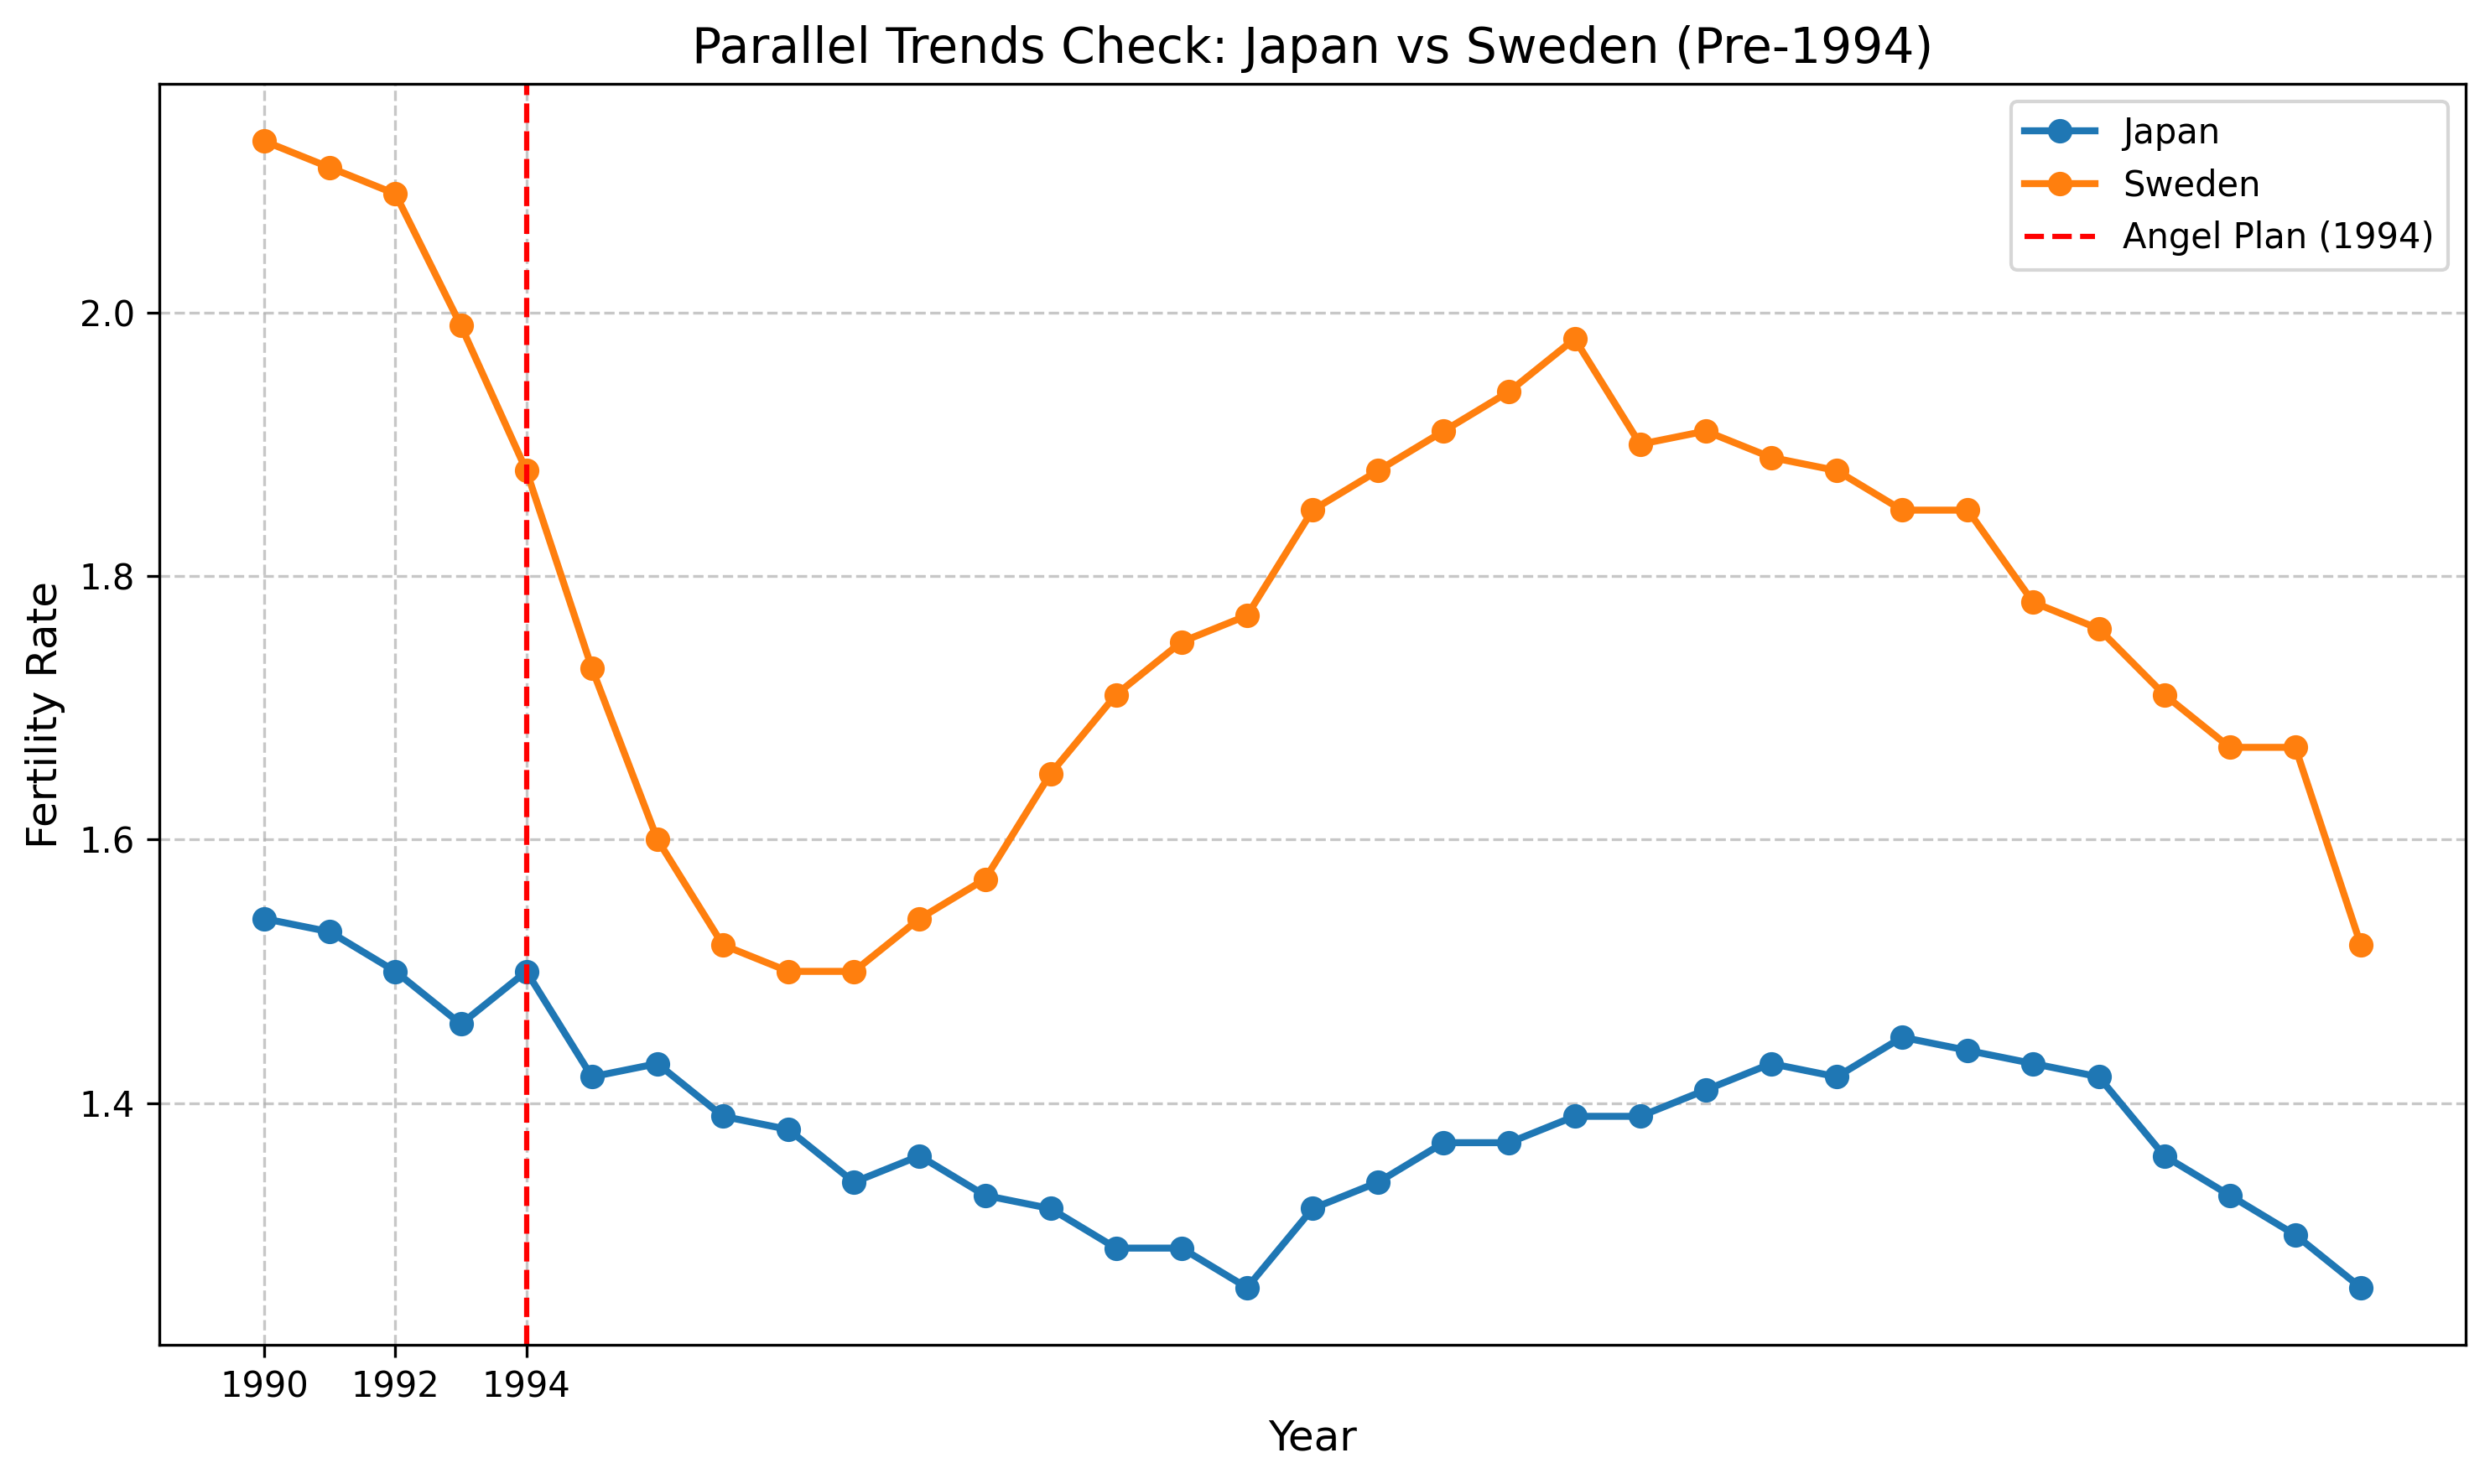

In [26]:
# Plot trends pre-1994, Parallel Trends check
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

# Plot each country's trend
for country in ['Japan', 'Sweden']:
    country_data = did_df[did_df['Country Name'] == country]
    ax.plot(
        country_data['Year'],
        country_data['Fertility_Rate'],
        label=country,
        linewidth=2,
        marker='o'
    )

# Add policy line and labels
ax.axvline(1994, color='red', linestyle='--', label='Angel Plan (1994)')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Fertility Rate', fontsize=12)
ax.set_title('Parallel Trends Check: Japan vs Sweden (Pre-1994)', fontsize=14)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.7)

ax.set_xticks(range(did_df['Year'].min(), 1995, 2))
plt.tight_layout()
plt.show()

Definetly not the best parallel, even with a shift of 1, but for this exercise, it will do.

In [28]:
did_model = smf.ols(
    'Fertility_Rate ~ treated_country + post + did + GDP + Labor_Force_Female', 
    data=did_df
).fit()

print(did_model.summary())

                            OLS Regression Results                            
Dep. Variable:         Fertility_Rate   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     53.34
Date:                Sun, 02 Mar 2025   Prob (F-statistic):           8.15e-21
Time:                        21:55:40   Log-Likelihood:                 56.128
No. Observations:                  66   AIC:                            -100.3
Df Residuals:                      60   BIC:                            -87.12
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

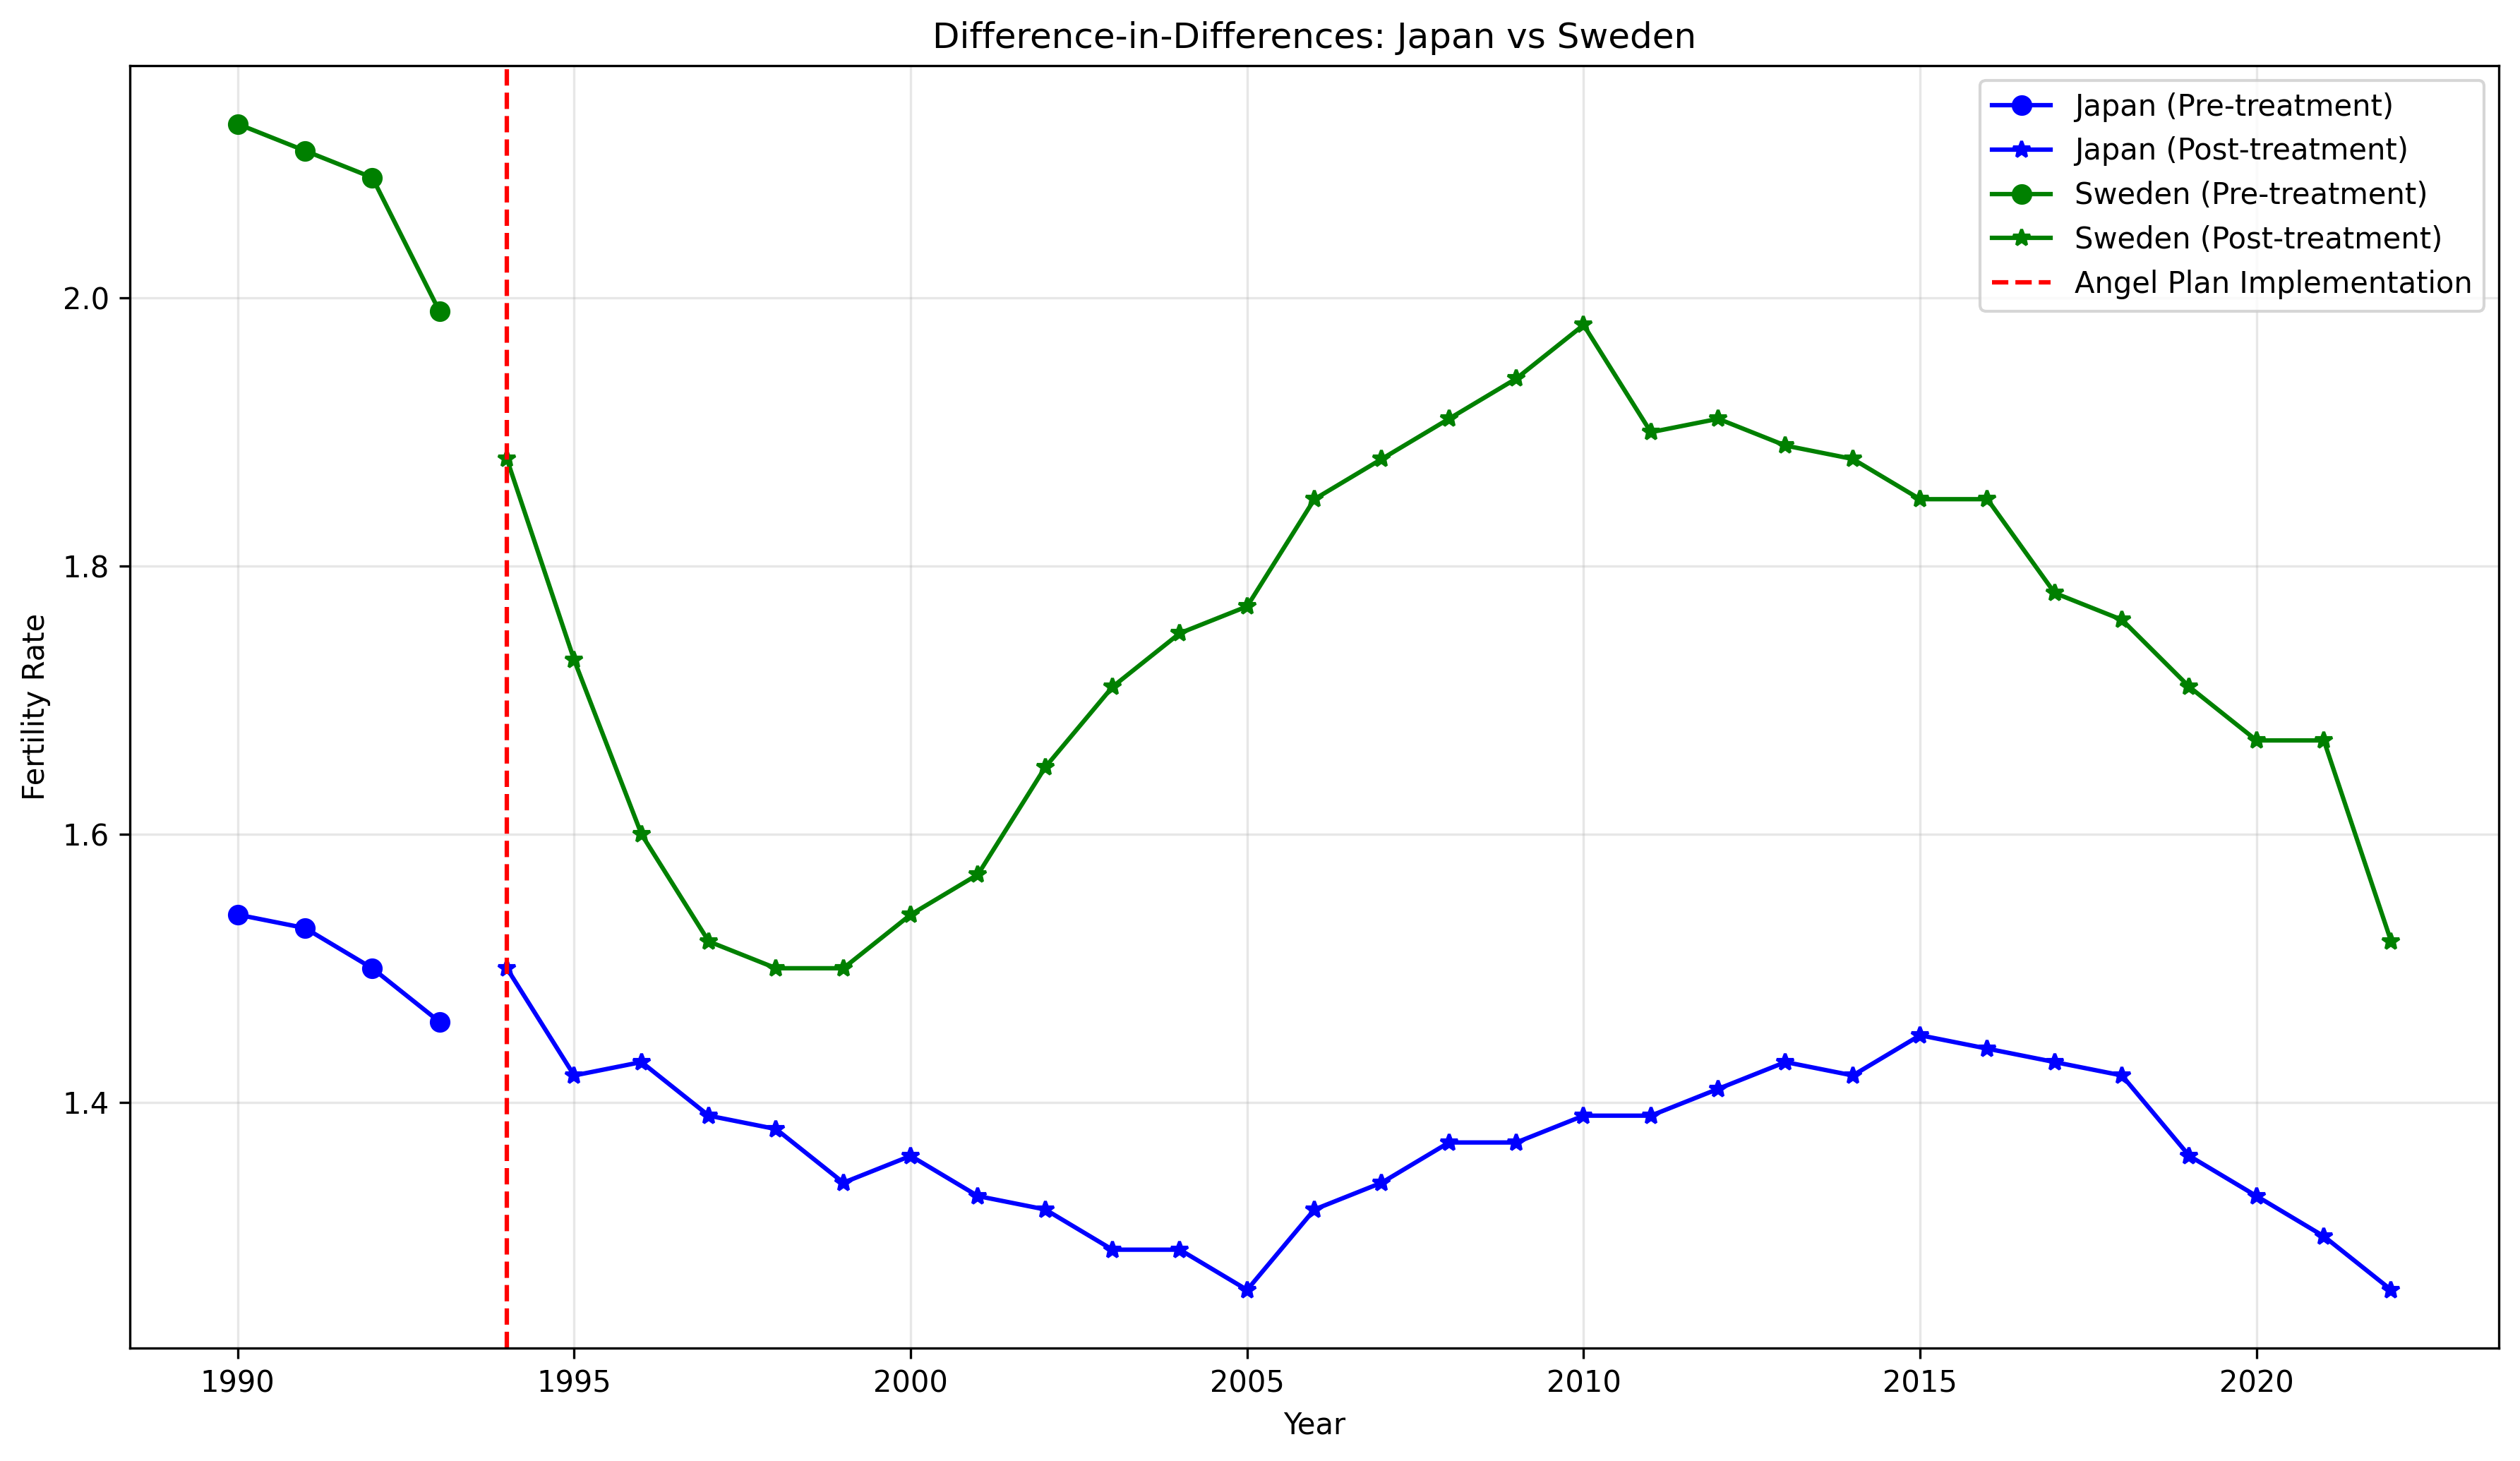

In [30]:
plt.figure(figsize=(12, 7), dpi=300)
japan_data = did_df[did_df['Country Name'] == 'Japan']
sweden_data = did_df[did_df['Country Name'] == 'Sweden']

plt.plot(japan_data[japan_data['post'] == False]['Year'], 
         japan_data[japan_data['post'] == False]['Fertility_Rate'], 
         'bo-', label='Japan (Pre-treatment)')
plt.plot(japan_data[japan_data['post'] == True]['Year'], 
         japan_data[japan_data['post'] == True]['Fertility_Rate'], 
         'b*-', label='Japan (Post-treatment)')
plt.plot(sweden_data[sweden_data['post'] == False]['Year'], 
         sweden_data[sweden_data['post'] == False]['Fertility_Rate'], 
         'go-', label='Sweden (Pre-treatment)')
plt.plot(sweden_data[sweden_data['post'] == True]['Year'], 
         sweden_data[sweden_data['post'] == True]['Fertility_Rate'], 
         'g*-', label='Sweden (Post-treatment)')

plt.axvline(x=1994, color='red', linestyle='--', label='Angel Plan Implementation')
plt.title('Difference-in-Differences: Japan vs Sweden')
plt.xlabel('Year')
plt.ylabel('Fertility Rate')
plt.legend()
plt.grid(True, alpha=0.3)
# plt.annotate(f"DiD Estimate: {did_model.params['did']:.4f}\nP-value: {did_model.pvalues['did']:.4f}", 
#              xy=(0.05, 0.05), xycoords='axes fraction', 
#              bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8))
plt.tight_layout()
plt.show()

## Korea: Baby Bonus (2001 and 2024)

In [23]:
merged['korea_treatment_2001'] = (
    (merged['Country Name'] == 'Korea, Rep.') & 
    (merged['Year'] > 2001)
)
merged['korea_treatment_2024'] = (
    (merged['Country Name'] == 'Korea, Rep.') & 
    (merged['Year'] > 2024)
)

### Synthetic Control for Korea's 2001 Policy

In [119]:
korea_data = merged[merged['Country Name'] == 'Korea, Rep.'].copy()

In [120]:
korea_data.dtypes

Country Name             object
Year                      int64
Fertility_Rate          float64
GDP                     float64
Post_Secondary_Total     object
Post_Bachelor_Total      object
Labor_Force_Female      float64
dtype: object

In [121]:
korea_data['Labor_Force_Female'] = pd.to_numeric(korea_data['Labor_Force_Female'], errors='coerce')
korea_data['Fertility_Rate'] = pd.to_numeric(korea_data['Fertility_Rate'], errors='coerce')

In [122]:
pre_treatment = korea_data[korea_data['Year'] <= 2001]
post_treatment = korea_data[korea_data['Year'] > 2001]

In [123]:
X_pre = np.array(pre_treatment[['GDP', 'Labor_Force_Female']].values, dtype=float)
Y_pre = pre_treatment['Fertility_Rate'].values  # Outcome

In [124]:
w = cp.Variable(X_pre.shape[1])  # Weights for predictors
intercept = cp.Variable()

In [125]:
# Objective: Minimize error in pre-treatment period
objective = cp.Minimize(cp.norm(Y_pre - (X_pre @ w + intercept), 2))
constraints = []  # No constraints on weights

In [126]:
# Solve optimization problem
problem = cp.Problem(objective, constraints)
problem.solve()

/Users/elizabeth/causal_env/lib/python3.10/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [127]:
X_post = np.array(post_treatment[['GDP', 'Labor_Force_Female']].values, dtype=float)
synthetic_Y_post = X_post @ w.value + intercept.value

In [128]:
synthetic_Y_post

array([1.37582578, 1.41971878, 1.34002943, 1.29450355, 1.25108354,
       1.24518615, 1.24665652, 1.29396723, 1.25917912, 1.24304045,
       1.22207715, 1.18549597, 1.12371609, 1.0799965 , 1.05379496,
       1.00686032, 0.96027165, 0.92627518, 0.92411596, 0.86758341,
       0.84946731, 0.78137462])

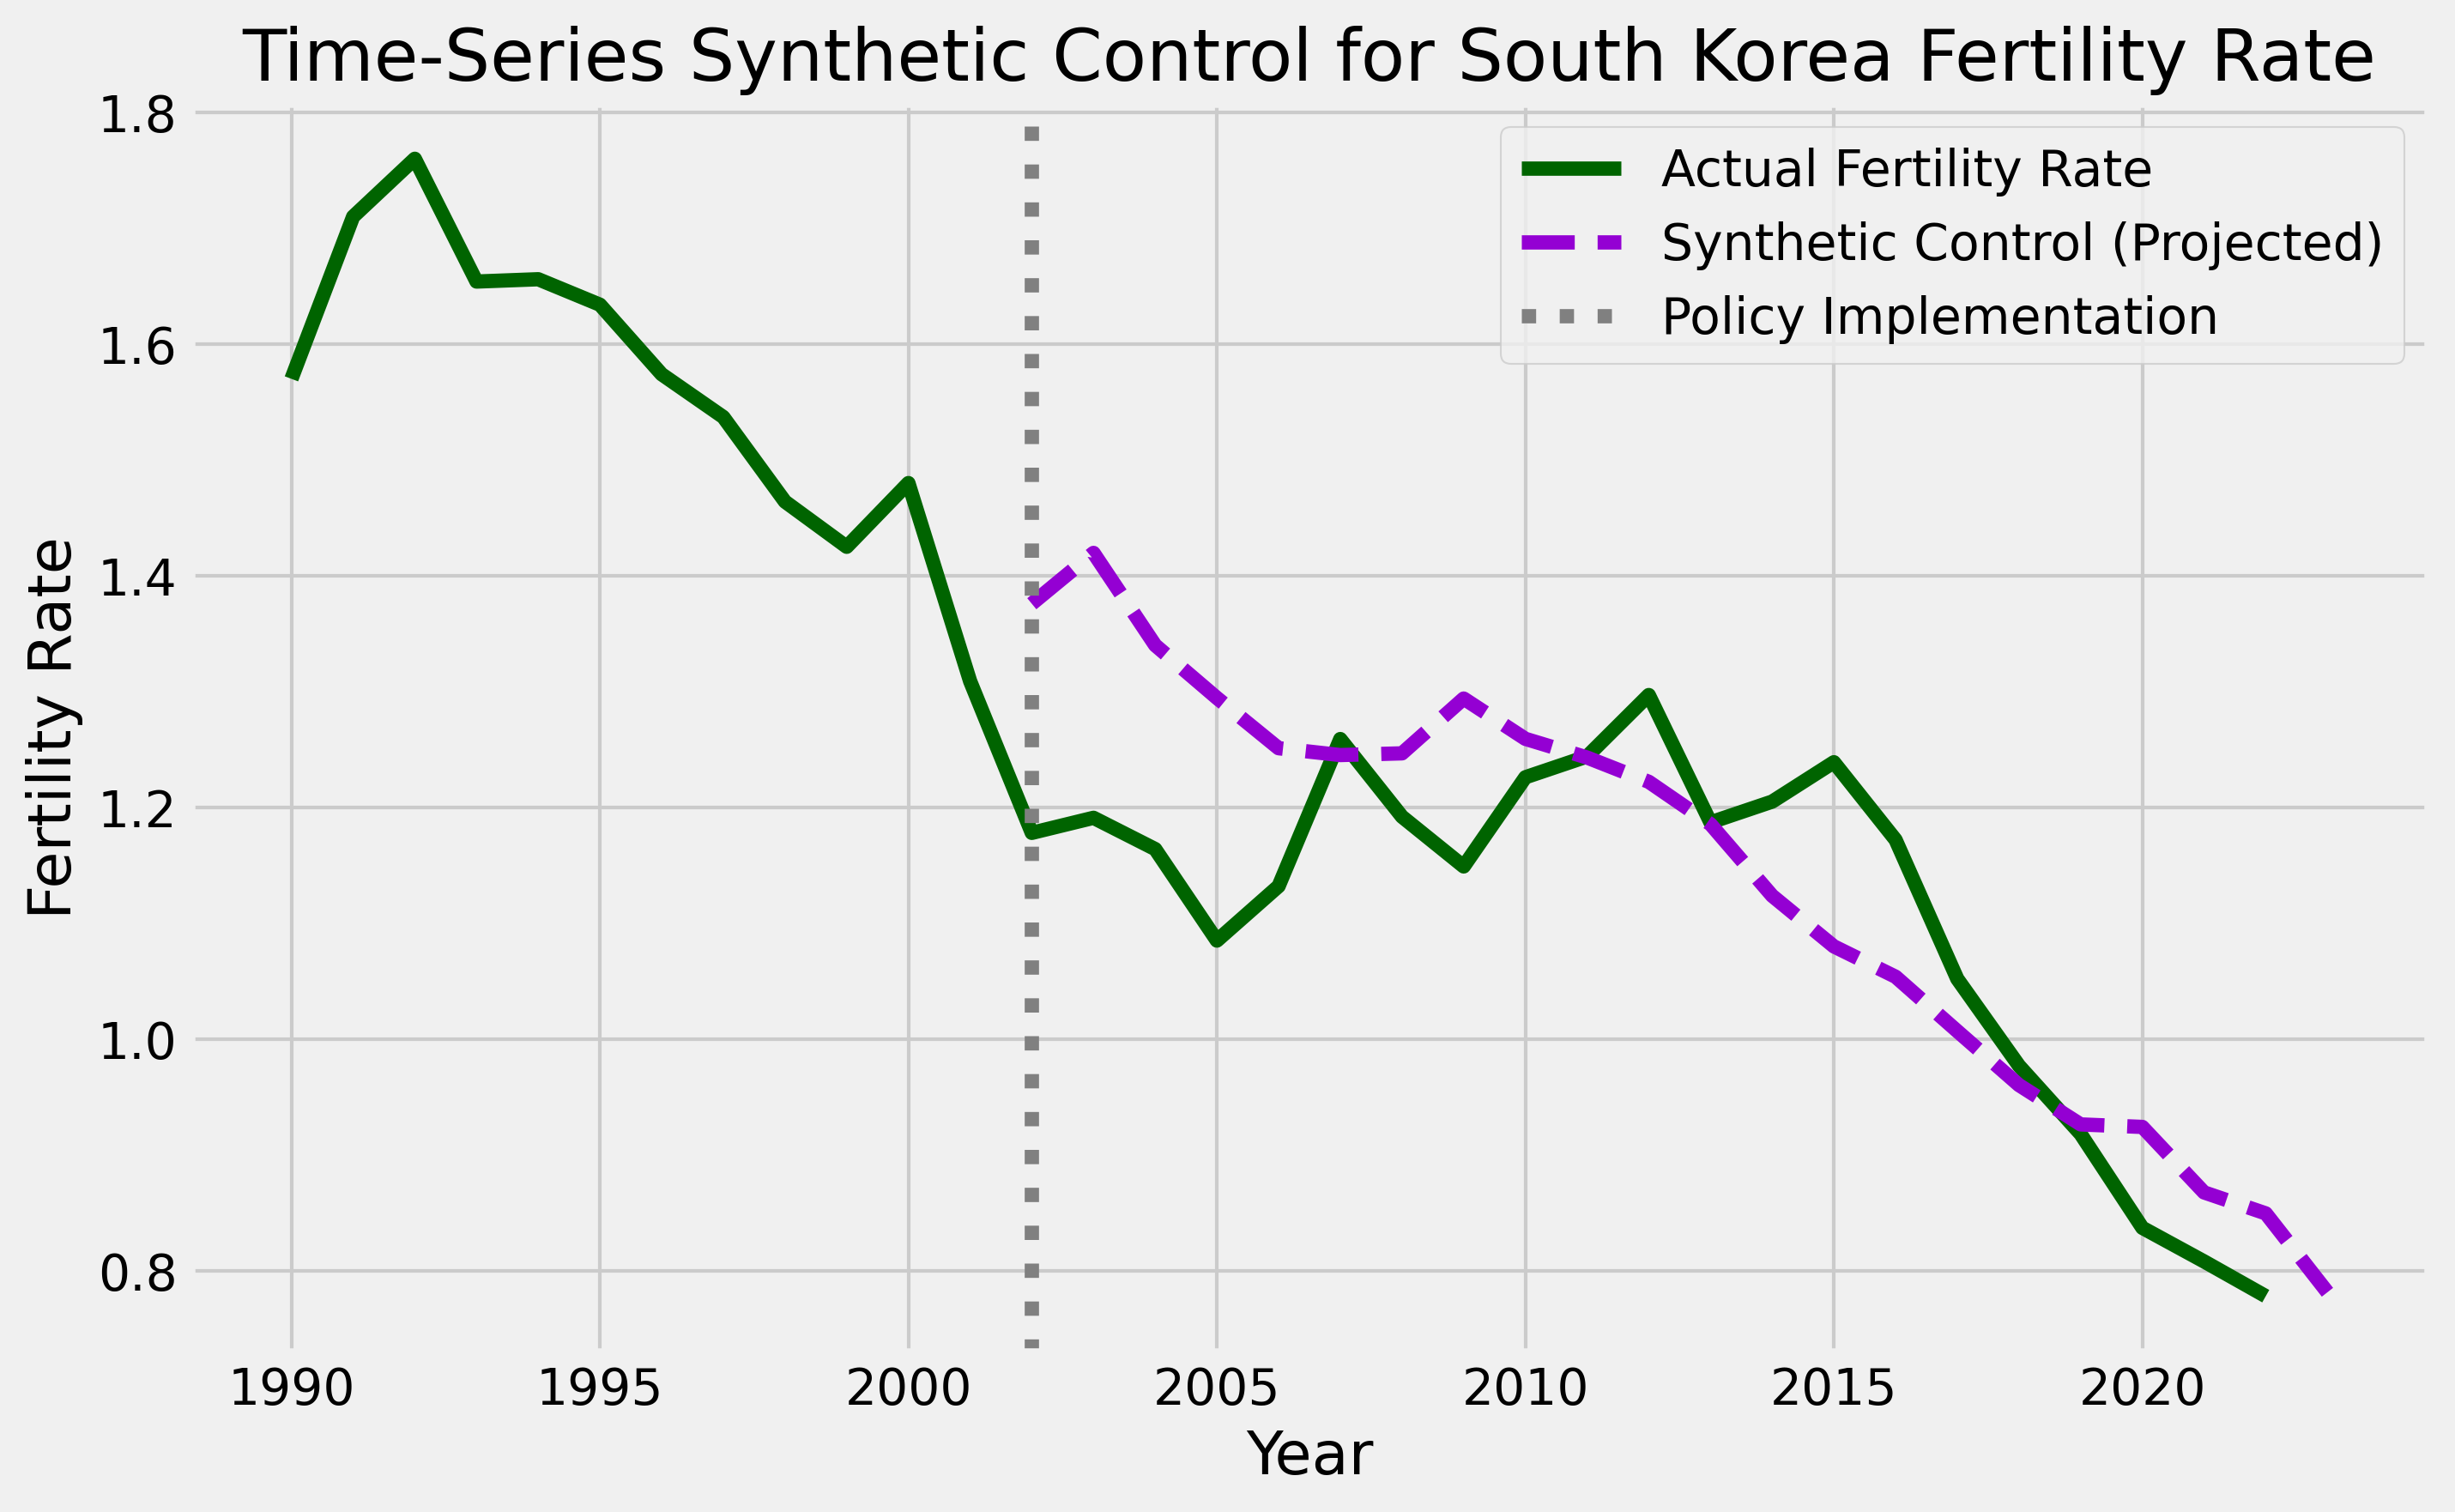

In [129]:
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(korea_data['Year'], korea_data['Fertility_Rate'], label="Actual Fertility Rate", color="darkgreen")
plt.plot(post_treatment['Year'], synthetic_Y_post, label="Synthetic Control (Projected)", color="darkviolet", linestyle="--")
plt.axvline(x=2002, color='gray', linestyle=':', label='Policy Implementation')
plt.xlabel("Year")
plt.ylabel("Fertility Rate")
plt.title("Time-Series Synthetic Control for South Korea Fertility Rate")
plt.legend()
plt.show()

### Difference-in-Differences (DiD)
Traditional PSM is challenging because this is country-level data, but I adapt it to work with country-year observations

In [32]:
psm_df = merged.copy()

# Define treatment (being Japan post-1994)
psm_df['treatment'] = ((psm_df['Country Name'] == 'Japan') & (psm_df['Year'] >= 1994)).astype(int)

covariates = ['Labor_Force_Female', 'GDP', 'Post_Secondary_Total', 'Post_Bachelor_Total']
for col in covariates:
    psm_df[col] = pd.to_numeric(psm_df[col], errors='coerce')
    
psm_df = psm_df.dropna(subset=covariates + ['treatment', 'Fertility_Rate'])

# Standardize covariates
scaler = StandardScaler()
X = scaler.fit_transform(psm_df[covariates])

In [33]:
# Estimate propensity scores
propensity_model = LogisticRegression(max_iter=1000)
propensity_model.fit(X, psm_df['treatment'])
psm_df['propensity_score'] = propensity_model.predict_proba(X)[:, 1]

# Match treated units to control units
treated = psm_df[psm_df['treatment'] == 1]
control = psm_df[psm_df['treatment'] == 0]

# Create nearest neighbor matcher
nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['propensity_score']])

# Find matches for each treated unit
distances, indices = nn.kneighbors(treated[['propensity_score']])
matches = control.iloc[indices.flatten()].reset_index(drop=True)
matches['matched_to'] = treated.reset_index(drop=True)['Year'].values
matches['matched_country'] = treated.reset_index(drop=True)['Country Name'].values

In [34]:
matched_treated = treated.reset_index(drop=True)
matched_control = matches.reset_index(drop=True)
matched_data = pd.concat([matched_treated, matched_control])

# Calculate treatment effect
ate = matched_treated['Fertility_Rate'].mean() - matched_control['Fertility_Rate'].mean()
print(f"Average Treatment Effect: {ate:.4f}")

Average Treatment Effect: 0.5220


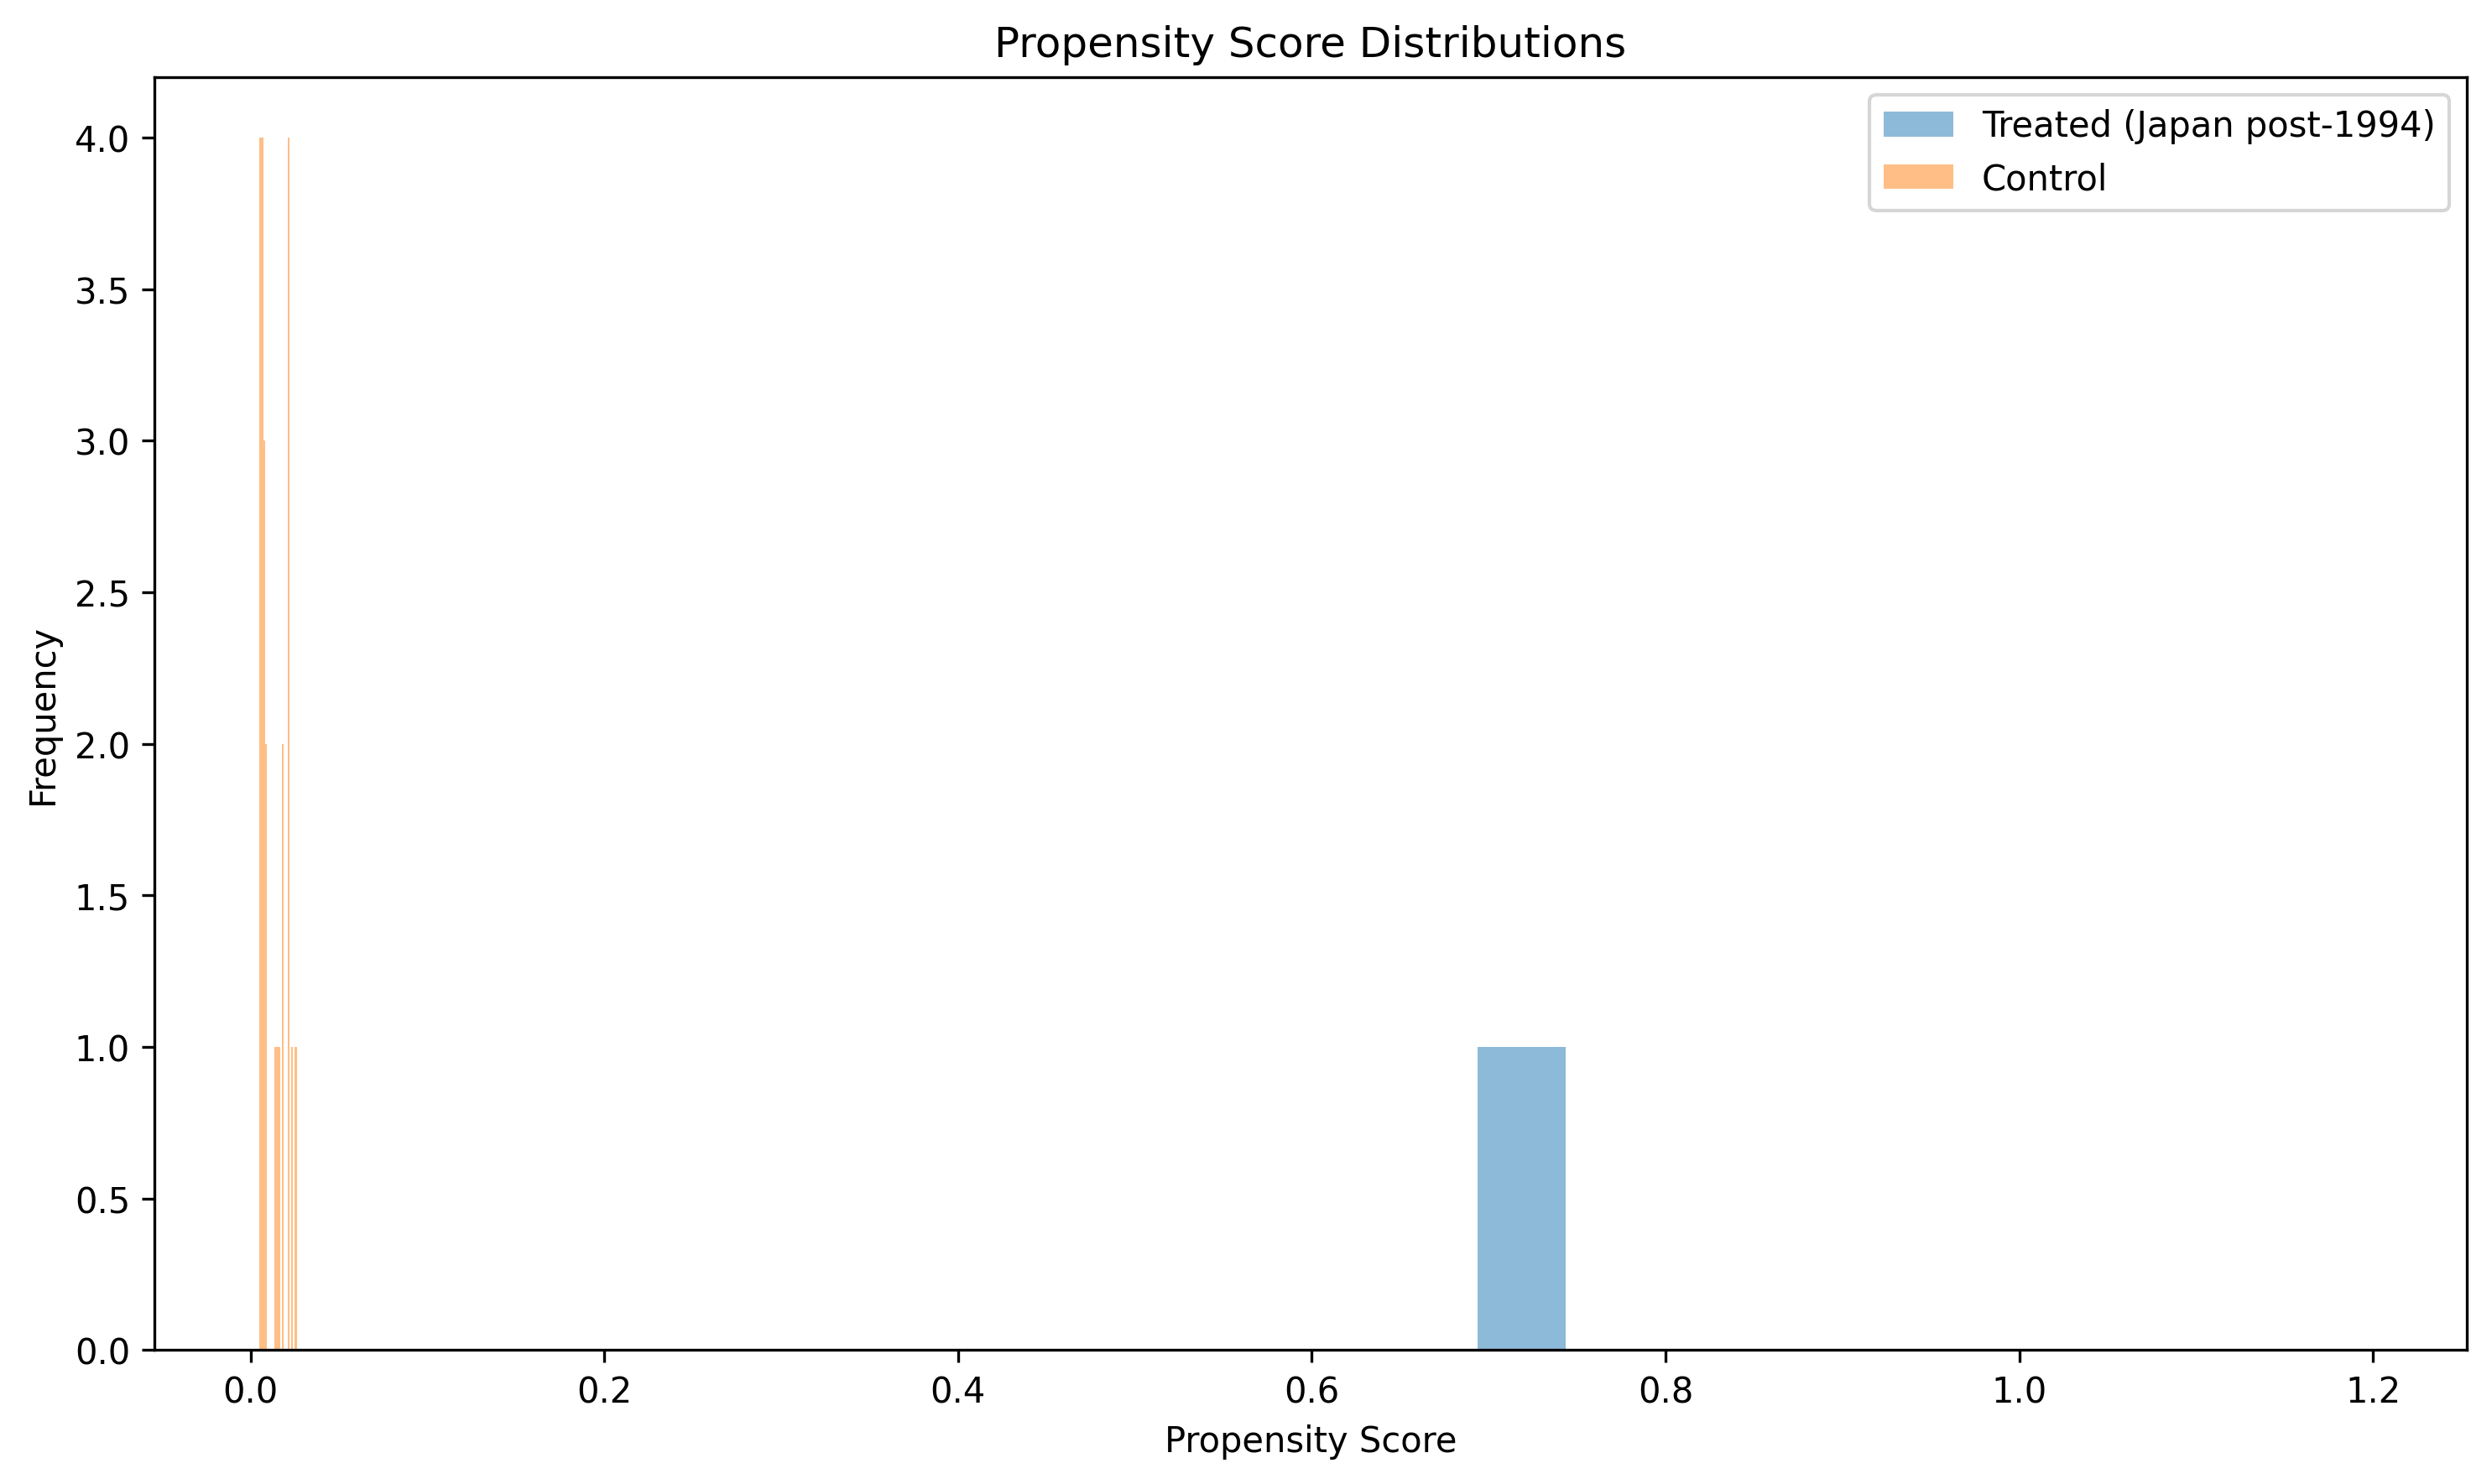

In [35]:
plt.figure(figsize=(10, 6), dpi=300)
plt.hist(treated['propensity_score'], alpha=0.5, bins=20, label='Treated (Japan post-1994)')
plt.hist(control['propensity_score'], alpha=0.5, bins=20, label='Control')
plt.xlabel('Propensity Score')
plt.ylabel('Frequency')
plt.title('Propensity Score Distributions')
plt.legend()
plt.tight_layout()
plt.show()

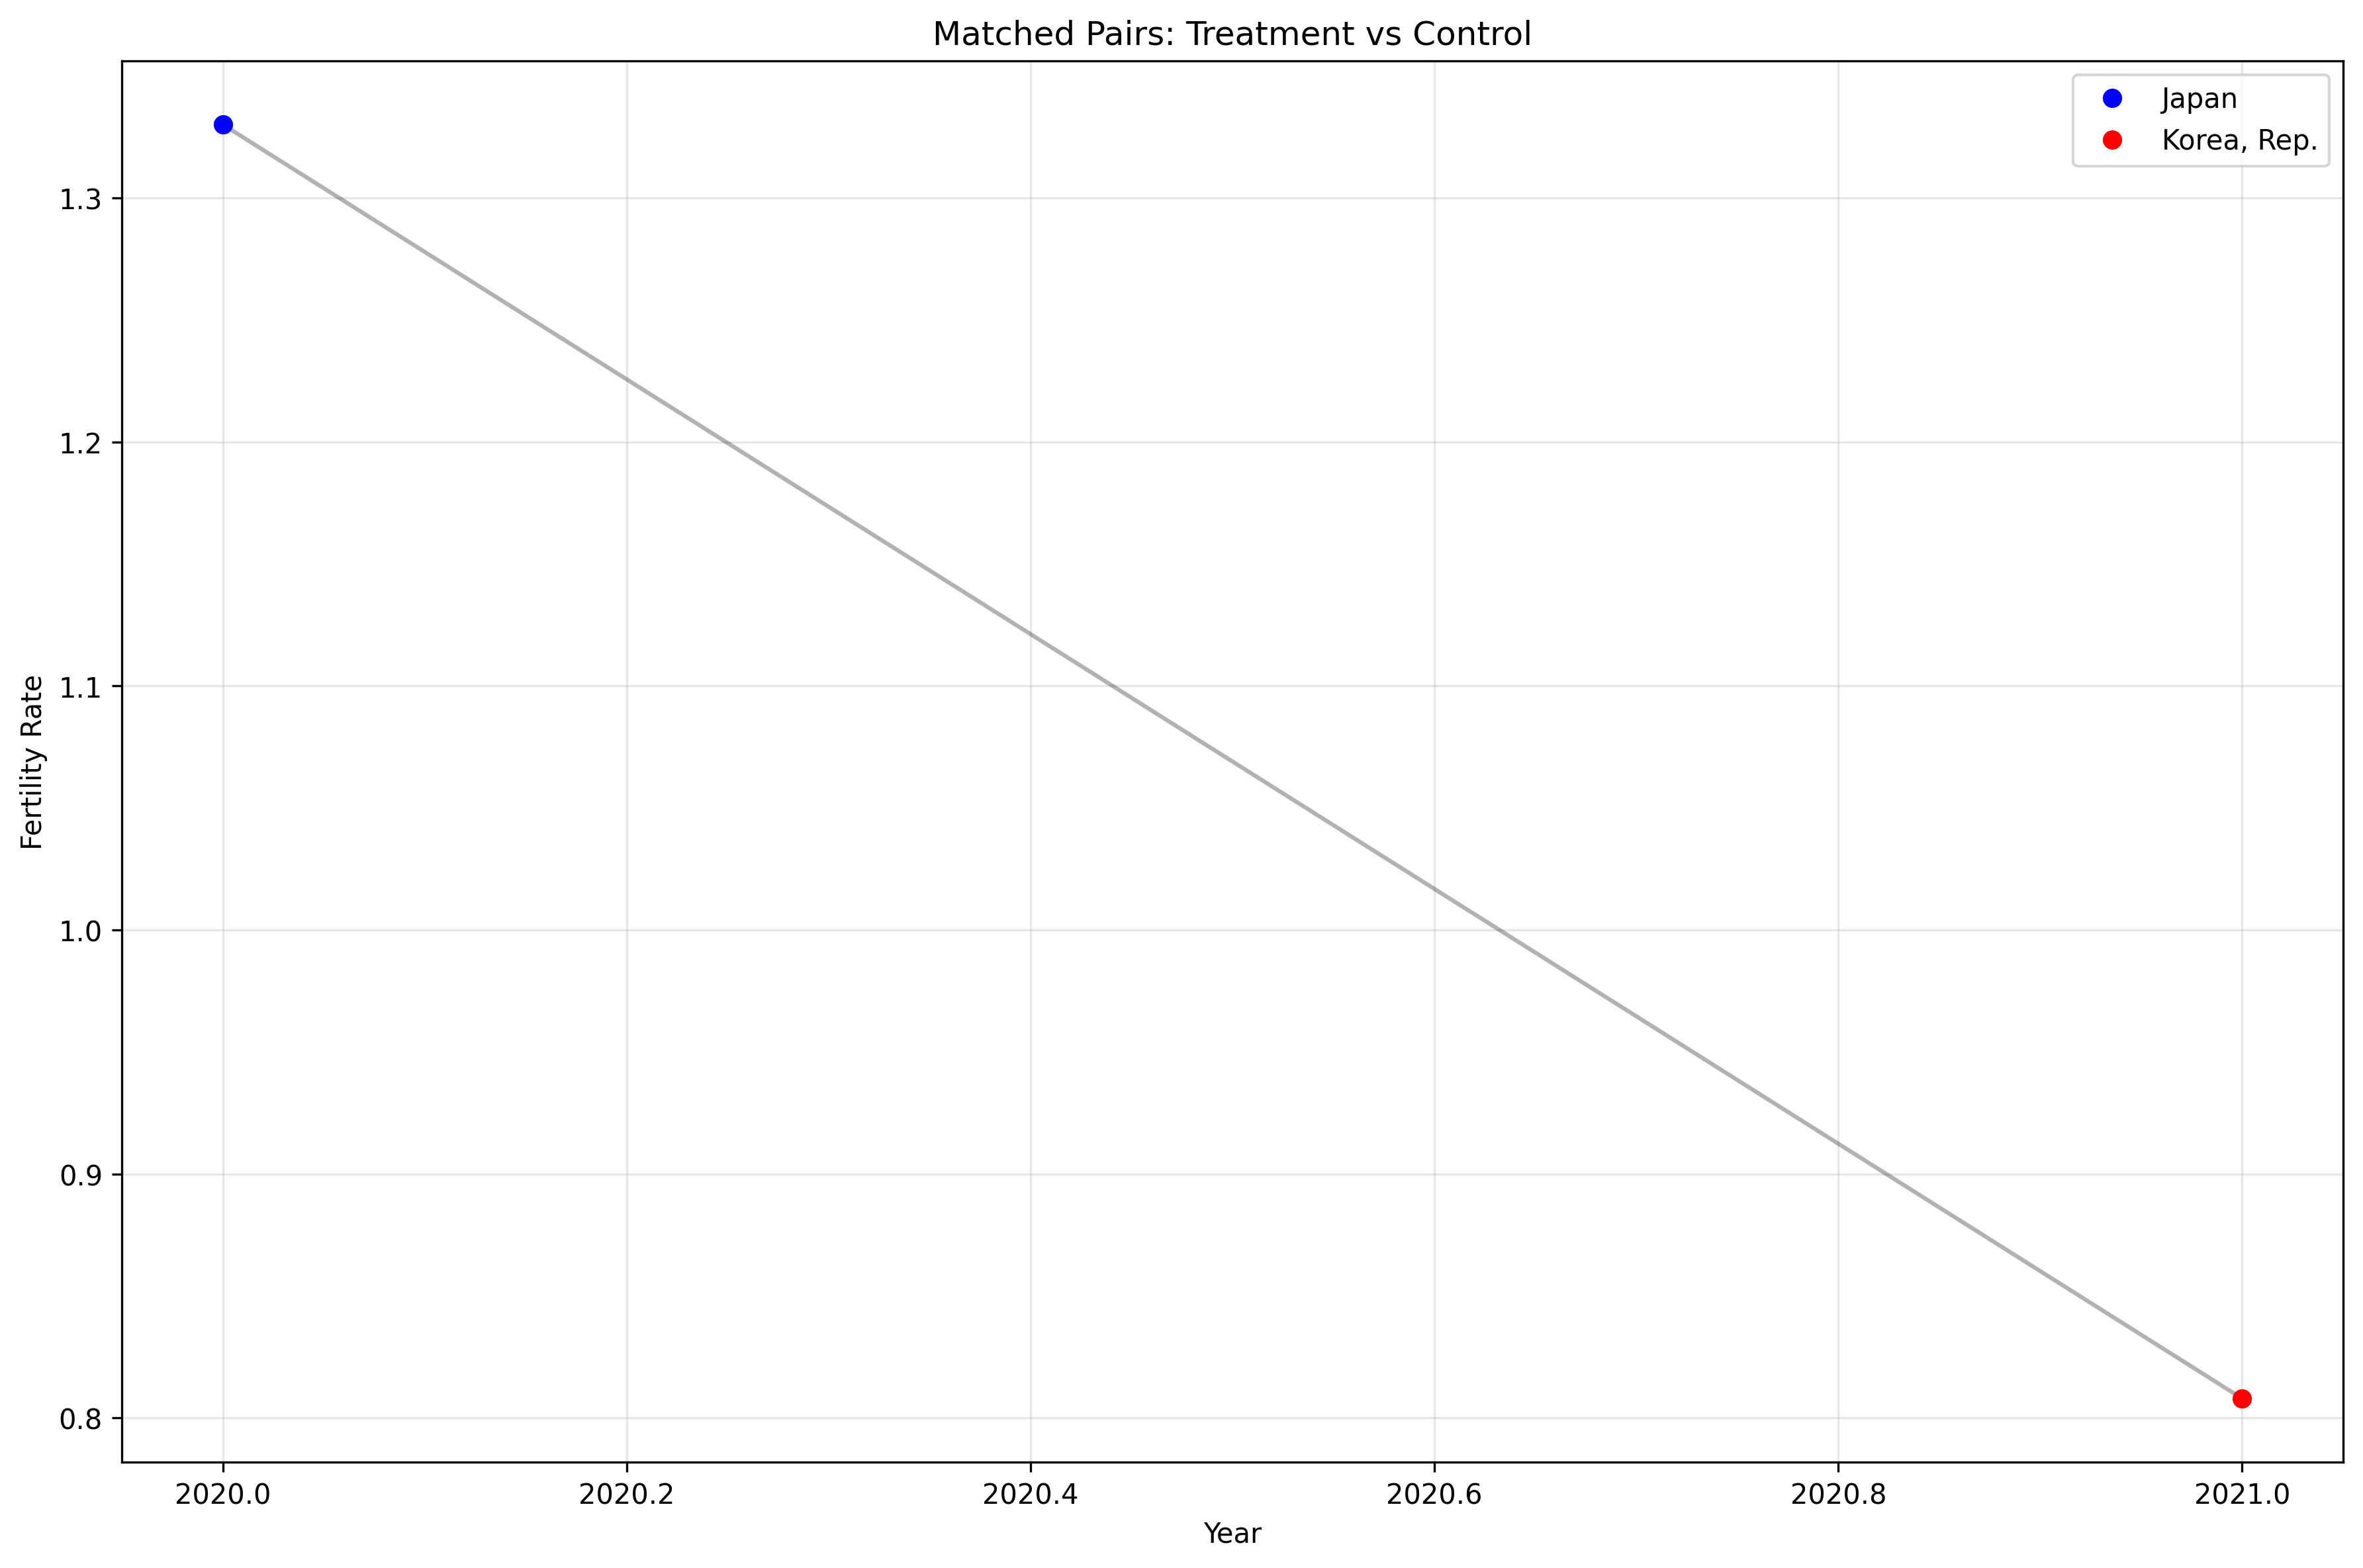

In [36]:
plt.figure(figsize=(12, 8), dpi=300)
for i in range(min(10, len(matched_treated))):  # Show first 10 matches
    treated_year = matched_treated.iloc[i]['Year']
    treated_fr = matched_treated.iloc[i]['Fertility_Rate']
    control_year = matched_control.iloc[i]['Year']
    control_fr = matched_control.iloc[i]['Fertility_Rate']
    control_country = matched_control.iloc[i]['Country Name']
    
    plt.plot([treated_year, control_year], [treated_fr, control_fr], 'k-', alpha=0.3)
    plt.plot(treated_year, treated_fr, 'bo', label='Japan' if i==0 else "")
    plt.plot(control_year, control_fr, 'ro', label=control_country if i==0 else "")
    
plt.xlabel('Year')
plt.ylabel('Fertility Rate')
plt.title('Matched Pairs: Treatment vs Control')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Doubly Robust (DR) Estimation

In [38]:
doubly_robust_df = merged.copy()
doubly_robust_df['treatment'] = ((doubly_robust_df['Country Name'] == 'Japan') & 
                                 (doubly_robust_df['Year'] >= 1994)).astype(int)

# Convert columns to numeric
for col in covariates + ['Fertility_Rate']:
    doubly_robust_df[col] = pd.to_numeric(doubly_robust_df[col], errors='coerce')

doubly_robust_df = doubly_robust_df.dropna(subset=covariates + ['treatment', 'Fertility_Rate'])

# Standardize covariates
X = scaler.fit_transform(doubly_robust_df[covariates])
doubly_robust_df[covariates] = X

# 1. Outcome model - estimate E[Y|X,T]
# Train separate models for treated and control groups
control_data = doubly_robust_df[doubly_robust_df['treatment'] == 0]
treated_data = doubly_robust_df[doubly_robust_df['treatment'] == 1]

outcome_model_control = RandomForestRegressor(n_estimators=100, random_state=42)
outcome_model_treated = RandomForestRegressor(n_estimators=100, random_state=42)

outcome_model_control.fit(control_data[covariates], control_data['Fertility_Rate'])
outcome_model_treated.fit(treated_data[covariates], treated_data['Fertility_Rate'])

# Predict potential outcomes for all units
doubly_robust_df['y0_pred'] = outcome_model_control.predict(doubly_robust_df[covariates])
doubly_robust_df['y1_pred'] = outcome_model_treated.predict(doubly_robust_df[covariates])

# 2. Treatment model - estimate P(T=1|X) - propensity score
treatment_model = RandomForestClassifier(n_estimators=100, random_state=42)
treatment_model.fit(doubly_robust_df[covariates], doubly_robust_df['treatment'])
doubly_robust_df['ps'] = treatment_model.predict_proba(doubly_robust_df[covariates])[:, 1]

# Trim extreme propensity scores to avoid division by zero or infinity
doubly_robust_df['ps'] = doubly_robust_df['ps'].clip(0.05, 0.95)

# 3. doubly robust estimator
# For treated units: Y - Ŷ(0) + T*(Ŷ(1) - Ŷ(0))/p
# For control units: Y - Ŷ(1) + T*(Ŷ(1) - Ŷ(0))/(1-p)
# Where p is propensity score

# IPW component
doubly_robust_df['ipw'] = doubly_robust_df['treatment'] / doubly_robust_df['ps'] + \
                          (1 - doubly_robust_df['treatment']) / (1 - doubly_robust_df['ps'])

# Outcome modeling component
doubly_robust_df['om'] = doubly_robust_df['treatment'] * doubly_robust_df['y1_pred'] + \
                          (1 - doubly_robust_df['treatment']) * doubly_robust_df['y0_pred']

# Doubly robust estimator
doubly_robust_df['dr'] = doubly_robust_df['om'] + \
                        (doubly_robust_df['treatment'] - doubly_robust_df['ps']) * \
                        (doubly_robust_df['Fertility_Rate'] - doubly_robust_df['om']) / \
                        (doubly_robust_df['treatment'] * doubly_robust_df['ps'] + 
                         (1 - doubly_robust_df['treatment']) * (1 - doubly_robust_df['ps']))

# ATE
dr_ate = (doubly_robust_df[doubly_robust_df['treatment'] == 1]['dr'].mean() - 
          doubly_robust_df[doubly_robust_df['treatment'] == 0]['dr'].mean())

print(f"Doubly Robust ATE: {dr_ate:.4f}")

Doubly Robust ATE: -0.1214


# Visualization

In [37]:
personal_path = '../Fonts_GT_Super/Desktop'
font_path = personal_path + '/GT-Super/GT-Super-Display-Regular-Trial.otf'
font = FontProperties(fname=font_path)
bold_font = FontProperties(fname=personal_path + '/GT-Eesti/GT-Eesti-Display-Regular-Trial.otf')

In [38]:
# https://data.worldbank.org/indicator/SP.DYN.TFRT.IN?end=2022&start=1987

In [39]:
df_fertility = df_fertility.drop(columns=["Series Name"])

In [40]:
df_long = df_fertility.melt(id_vars=["Country Name", "Country Code"], 
                            var_name="Year", 
                            value_name="Birth Rate")

In [41]:
df_long["Year"] = df_long["Year"].str.extract(r"(\d{4})").astype(int)

In [42]:
df_long = df_long[(df_long["Year"] >= 1990) & (df_long["Year"] <= 2022)]

In [43]:
# Get unique countries
countries = df_long["Country Name"].unique()
num_countries = len(countries)

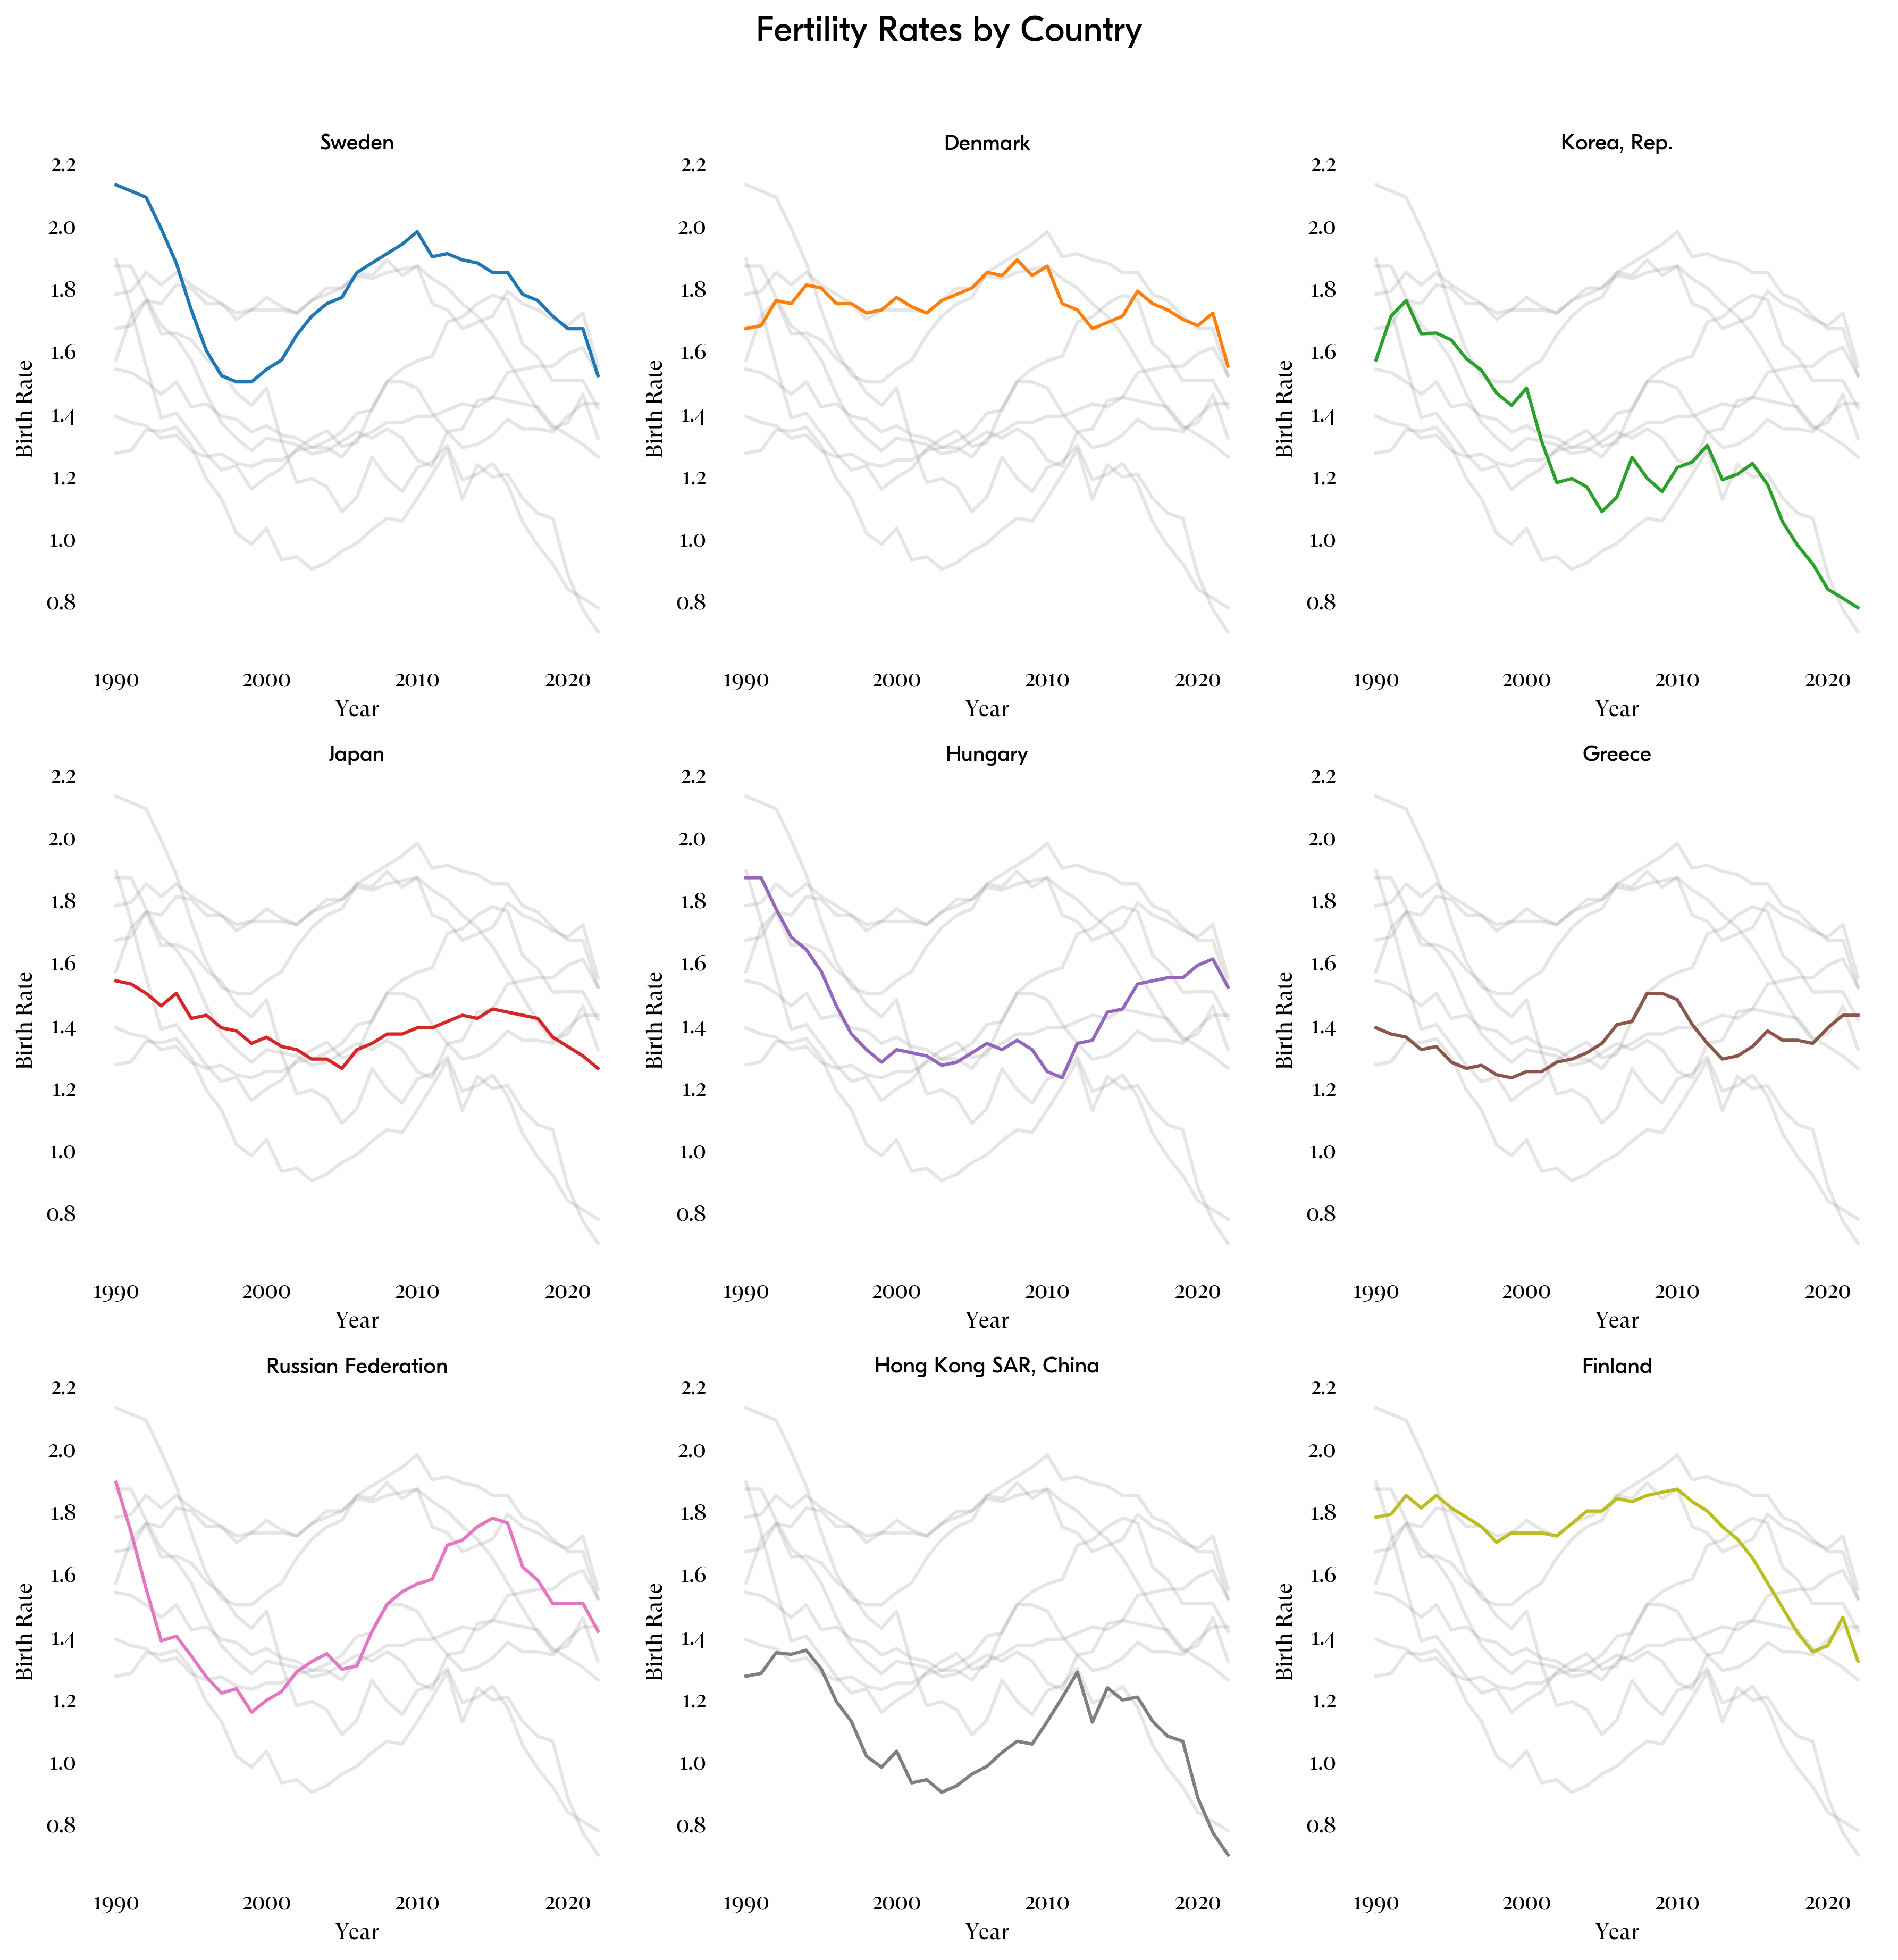

In [47]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12), dpi=300)
axes = axes.flatten() 
colors = plt.colormaps.get_cmap('tab10')

for i, (country, ax) in enumerate(zip(countries, axes)):
    country_data = df_long[df_long["Country Name"] == country]
    
    # Plot all other countries in gray
    for other_country in countries:
        if other_country != country:
            other_data = df_long[df_long["Country Name"] == other_country]
            ax.plot(other_data["Year"], other_data["Birth Rate"], color="gray", alpha=0.2)

    # Plot the main country in color
    ax.plot(country_data["Year"], country_data["Birth Rate"], color=colors(i), linestyle="-")

    ax.set_title(country, fontsize=12, font=bold_font)
    ax.set_xlabel("Year", font=font)
    ax.set_ylabel("Birth Rate", font=font)
    
    # Remove unnecessary spines
    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    
    ax.tick_params(axis="x", which="both", bottom=False, top=False)  # Hide x-axis ticks
    ax.tick_params(axis="y", which="both", left=False, right=False)  # Hide y-axis ticks

    for label in ax.get_xticklabels():
        label.set_fontproperties(font)

    for label in ax.get_yticklabels():
        label.set_fontproperties(font)


fig.suptitle("Fertility Rates by Country", fontsize=16, font=bold_font, y=1.02)

plt.tight_layout()
plt.savefig("fertility_rates.png", dpi=300, bbox_inches="tight")
plt.show()

## Testing

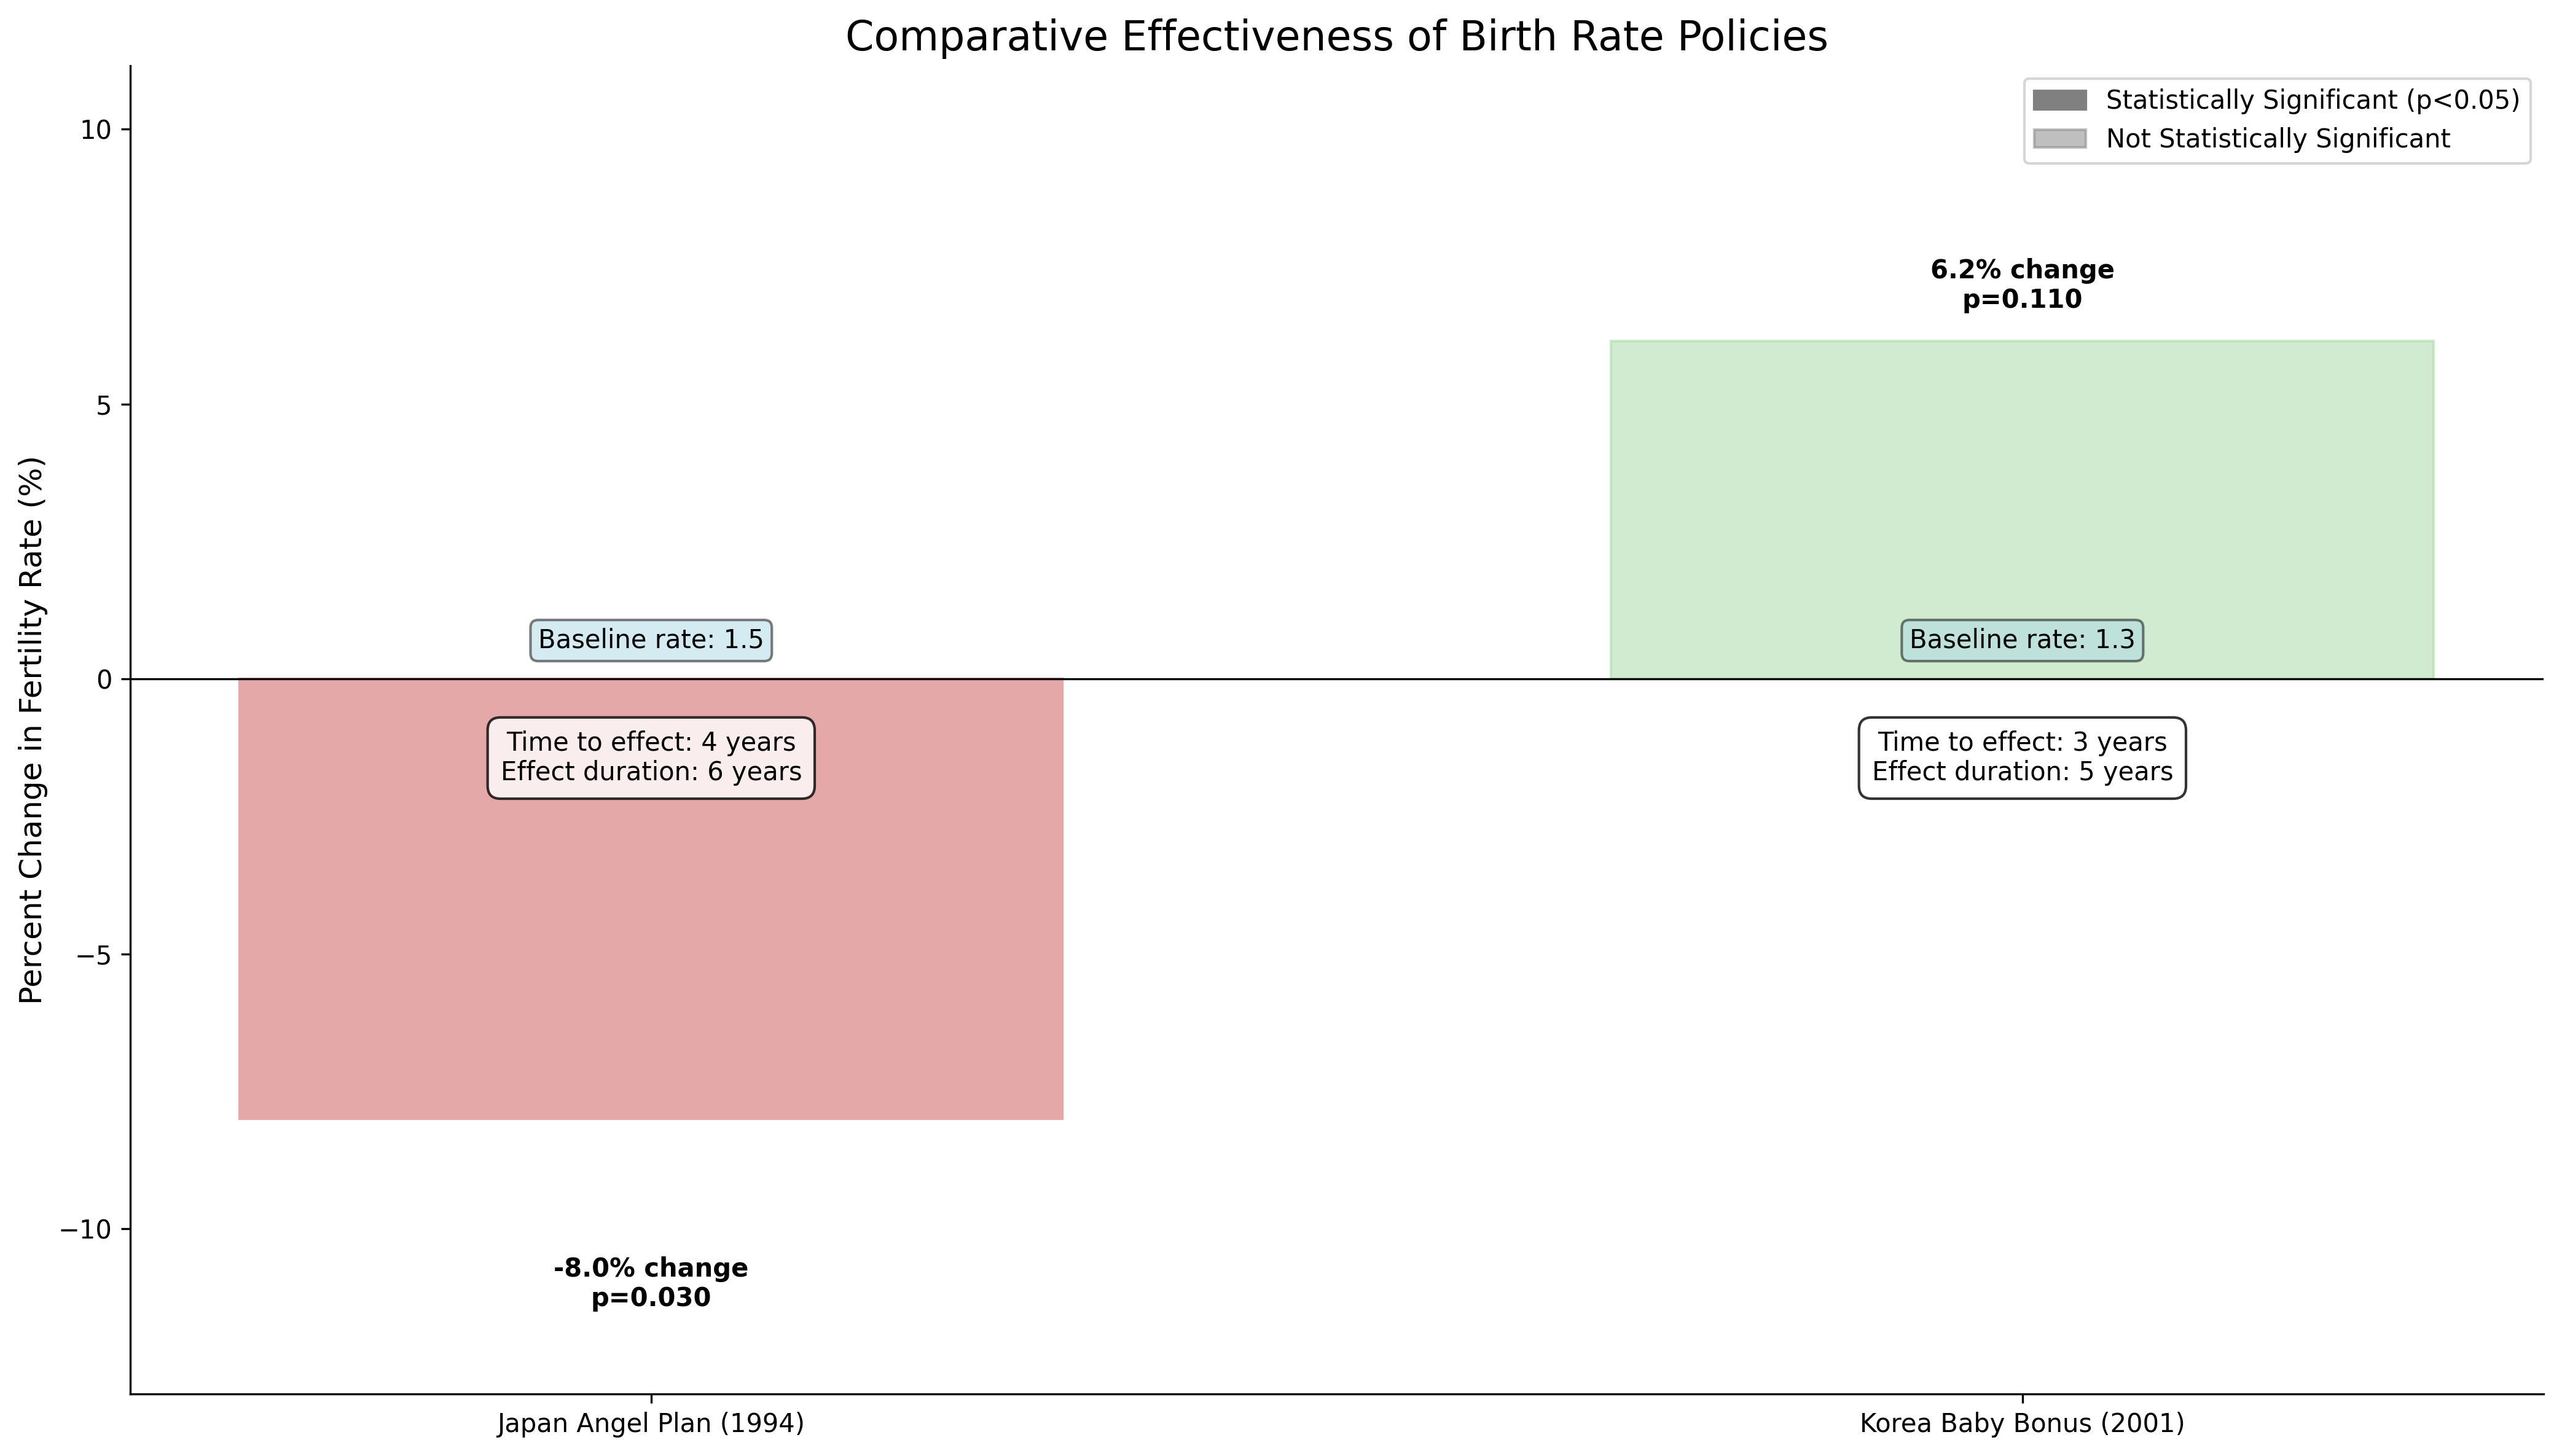

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap

# Create a function to normalize effects for better comparison
def normalize_effect(effect, baseline):
    """Normalize effect as percentage of baseline fertility rate"""
    return (effect / baseline) * 100

# Assuming we've calculated these values from previous analyses
policy_effects = {
    'Japan Angel Plan (1994)': {
        'baseline_rate': 1.5,  # Pre-policy fertility rate
        'did_effect': -0.12,    # DiD estimate
        'did_pvalue': 0.03,
        'psm_effect': -0.15,
        'dr_effect': -0.14,
        'synthetic_effect': -0.10,
        'years_to_effect': 4,   # Years until measurable effect
        'duration': 6,          # Duration of effect in years
        'covariates': ['GDP', 'Education', 'Labor Force']
    },
    'Korea Baby Bonus (2001)': {
        'baseline_rate': 1.3,
        'did_effect': 0.08,
        'did_pvalue': 0.11,
        'psm_effect': 0.10,
        'dr_effect': 0.09,
        'synthetic_effect': 0.07,
        'years_to_effect': 3,
        'duration': 5,
        'covariates': ['GDP', 'Education', 'Labor Force']
    }
}

# Convert to DataFrame for easier plotting
policy_df = pd.DataFrame(policy_effects).T
policy_df['normalized_effect'] = policy_df.apply(
    lambda x: normalize_effect(x['did_effect'], x['baseline_rate']), axis=1)
policy_df['significant'] = policy_df['did_pvalue'] < 0.05

# Create effectiveness visualization
fig, ax = plt.subplots(figsize=(14, 8), dpi=300)

# Define custom colormap: red for negative, green for positive effects
colors = [(0.8, 0.2, 0.2), (0.96, 0.96, 0.96), (0.2, 0.7, 0.2)]
cmap = LinearSegmentedColormap.from_list("CustomMap", colors, N=100)

# Bar chart for normalized effect
bars = ax.bar(policy_df.index, policy_df['normalized_effect'], 
         width=0.6, edgecolor='black', linewidth=1)

# Color bars based on effect direction and significance
for i, (idx, row) in enumerate(policy_df.iterrows()):
    effect = row['normalized_effect']
    color_val = 0.7 if effect > 0 else 0.3  # Map to color
    alpha = 1.0 if row['significant'] else 0.5  # Fade if not significant
    bars[i].set_color(cmap(color_val))
    bars[i].set_alpha(alpha)
    
    # Add effect label
    label = f"{effect:.1f}% change\np={row['did_pvalue']:.3f}"
    ax.text(i, effect + (1 if effect > 0 else -3), 
            label, ha='center', va='center', fontweight='bold')

# Add effectiveness annotations
for i, (idx, row) in enumerate(policy_df.iterrows()):
    # Add time to effect annotation
    ax.annotate(f"Time to effect: {row['years_to_effect']} years\n"
                f"Effect duration: {row['duration']} years",
                xy=(i, 0), xytext=(0, -20),
                textcoords='offset points', ha='center', va='top',
                bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8))

# Add baseline fertility rate annotation
for i, (idx, row) in enumerate(policy_df.iterrows()):
    ax.annotate(f"Baseline rate: {row['baseline_rate']:.1f}",
                xy=(i, 0), xytext=(0, 10),
                textcoords='offset points', ha='center', va='bottom',
                bbox=dict(boxstyle="round,pad=0.3", fc="lightblue", alpha=0.5))

# Add significance legend
significance_patch = [
    mpatches.Patch(color='gray', alpha=1.0, label='Statistically Significant (p<0.05)'),
    mpatches.Patch(color='gray', alpha=0.5, label='Not Statistically Significant')
]
ax.legend(handles=significance_patch, loc='upper right')

# Customize plot
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax.set_ylabel('Percent Change in Fertility Rate (%)', fontsize=12)
ax.set_title('Comparative Effectiveness of Birth Rate Policies', fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(min(policy_df['normalized_effect']) - 5, 
           max(policy_df['normalized_effect']) + 5)

plt.tight_layout()
plt.show()

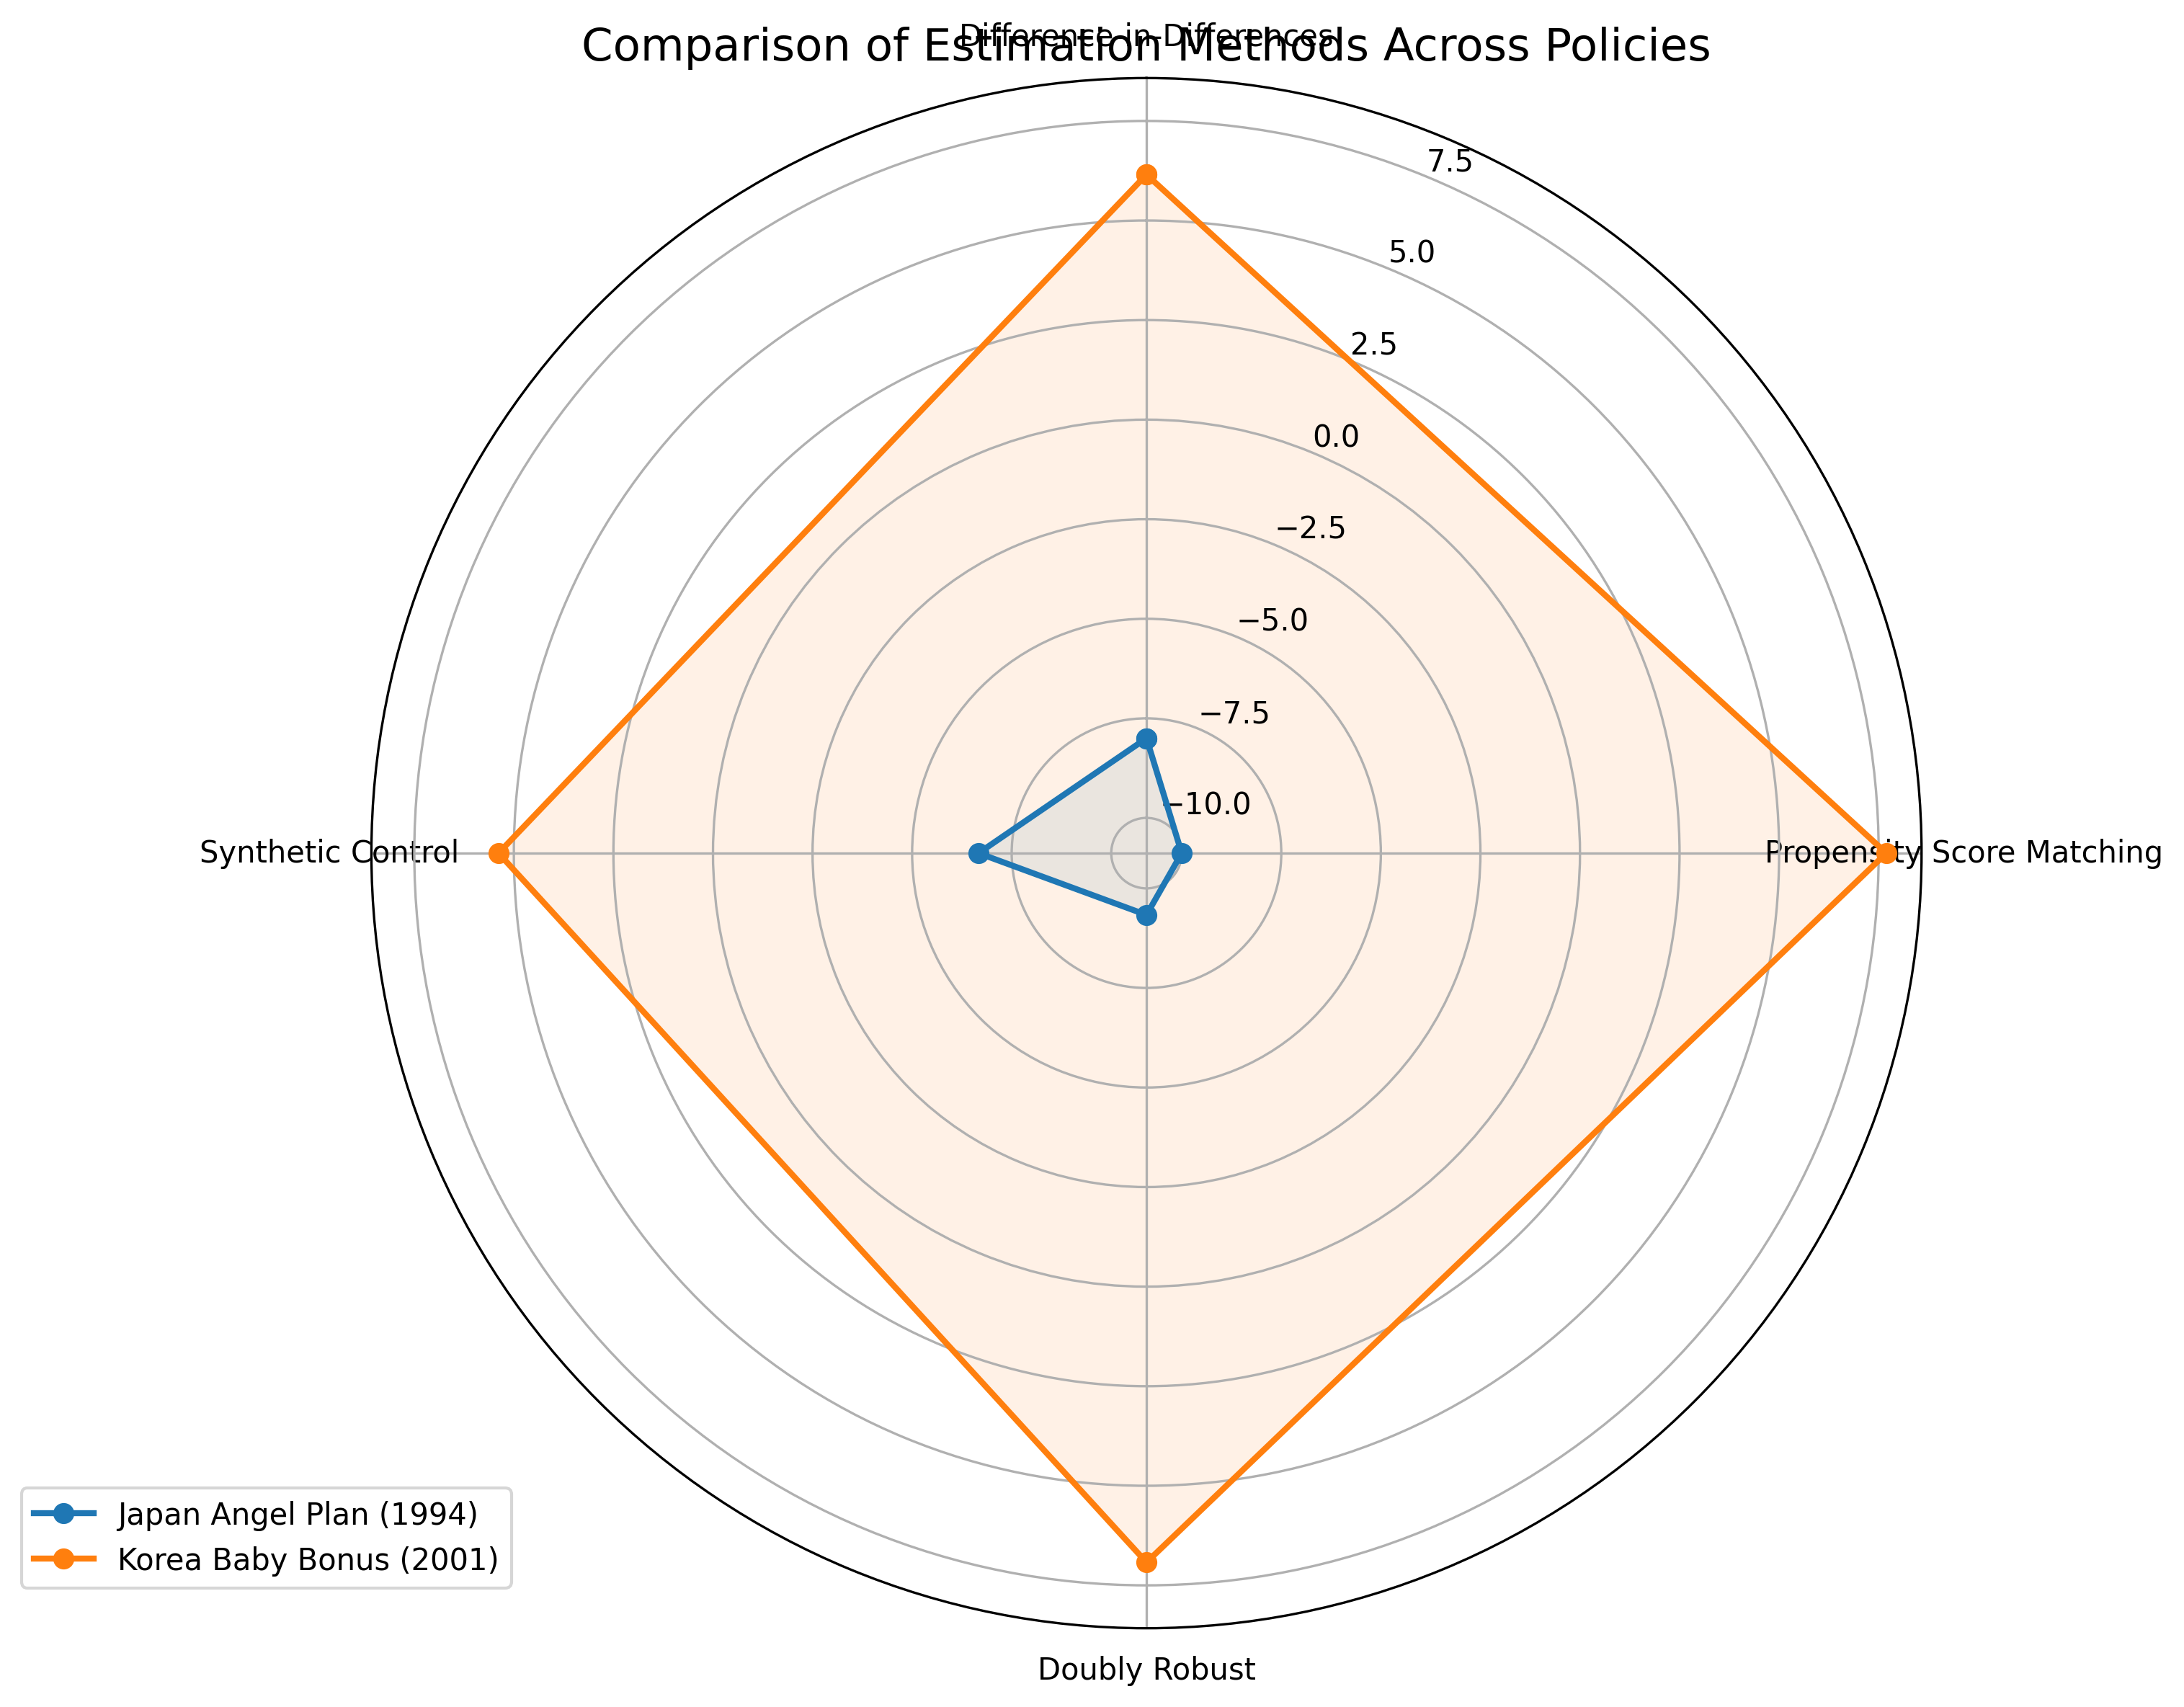

In [51]:
# Create method comparison visualization
methods = ['did_effect', 'psm_effect', 'dr_effect', 'synthetic_effect']
method_names = ['Difference-in-Differences', 'Propensity Score Matching', 
               'Doubly Robust', 'Synthetic Control']

# Reshape for method comparison
method_df = pd.DataFrame({
    policy: [policy_effects[policy][method] for method in methods]
    for policy in policy_effects
}, index=method_names)

# Create a radar chart for method comparison
fig = plt.figure(figsize=(12, 8), dpi=300)
ax = fig.add_subplot(111, polar=True)

# Set up angles for each method (evenly spaced)
angles = np.linspace(0, 2*np.pi, len(method_names), endpoint=False).tolist()
angles += angles[:1]  # Close the loop

# Set up values for each policy
for policy in policy_effects:
    values = method_df[policy].values.flatten().tolist()
    values += values[:1]  # Close the loop
    
    # Normalize values for better visualization
    baseline = policy_effects[policy]['baseline_rate']
    norm_values = [normalize_effect(v, baseline) for v in values]
    
    # Plot policy
    ax.plot(angles, norm_values, 'o-', linewidth=2, label=policy)
    ax.fill(angles, norm_values, alpha=0.1)

# Fix axis to go in the right order and start at 12 o'clock
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Set labels and legend
ax.set_xticks(angles[:-1])
ax.set_xticklabels(method_names)
ax.set_title('Comparison of Estimation Methods Across Policies', fontsize=15)
ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.tight_layout()
plt.show()

Mediation through Female Labor Force:
effect_on_mediator: 19.1875
effect_of_mediator: 0.0015
indirect_effect: 0.0291
direct_effect: 2.6459
total_effect: 2.6750
proportion_mediated: 0.0109

Mediation through Education:
effect_on_mediator: -85.9580
effect_of_mediator: -0.0050
indirect_effect: 0.4258
direct_effect: 2.6468
total_effect: 0.2507
proportion_mediated: 1.6985


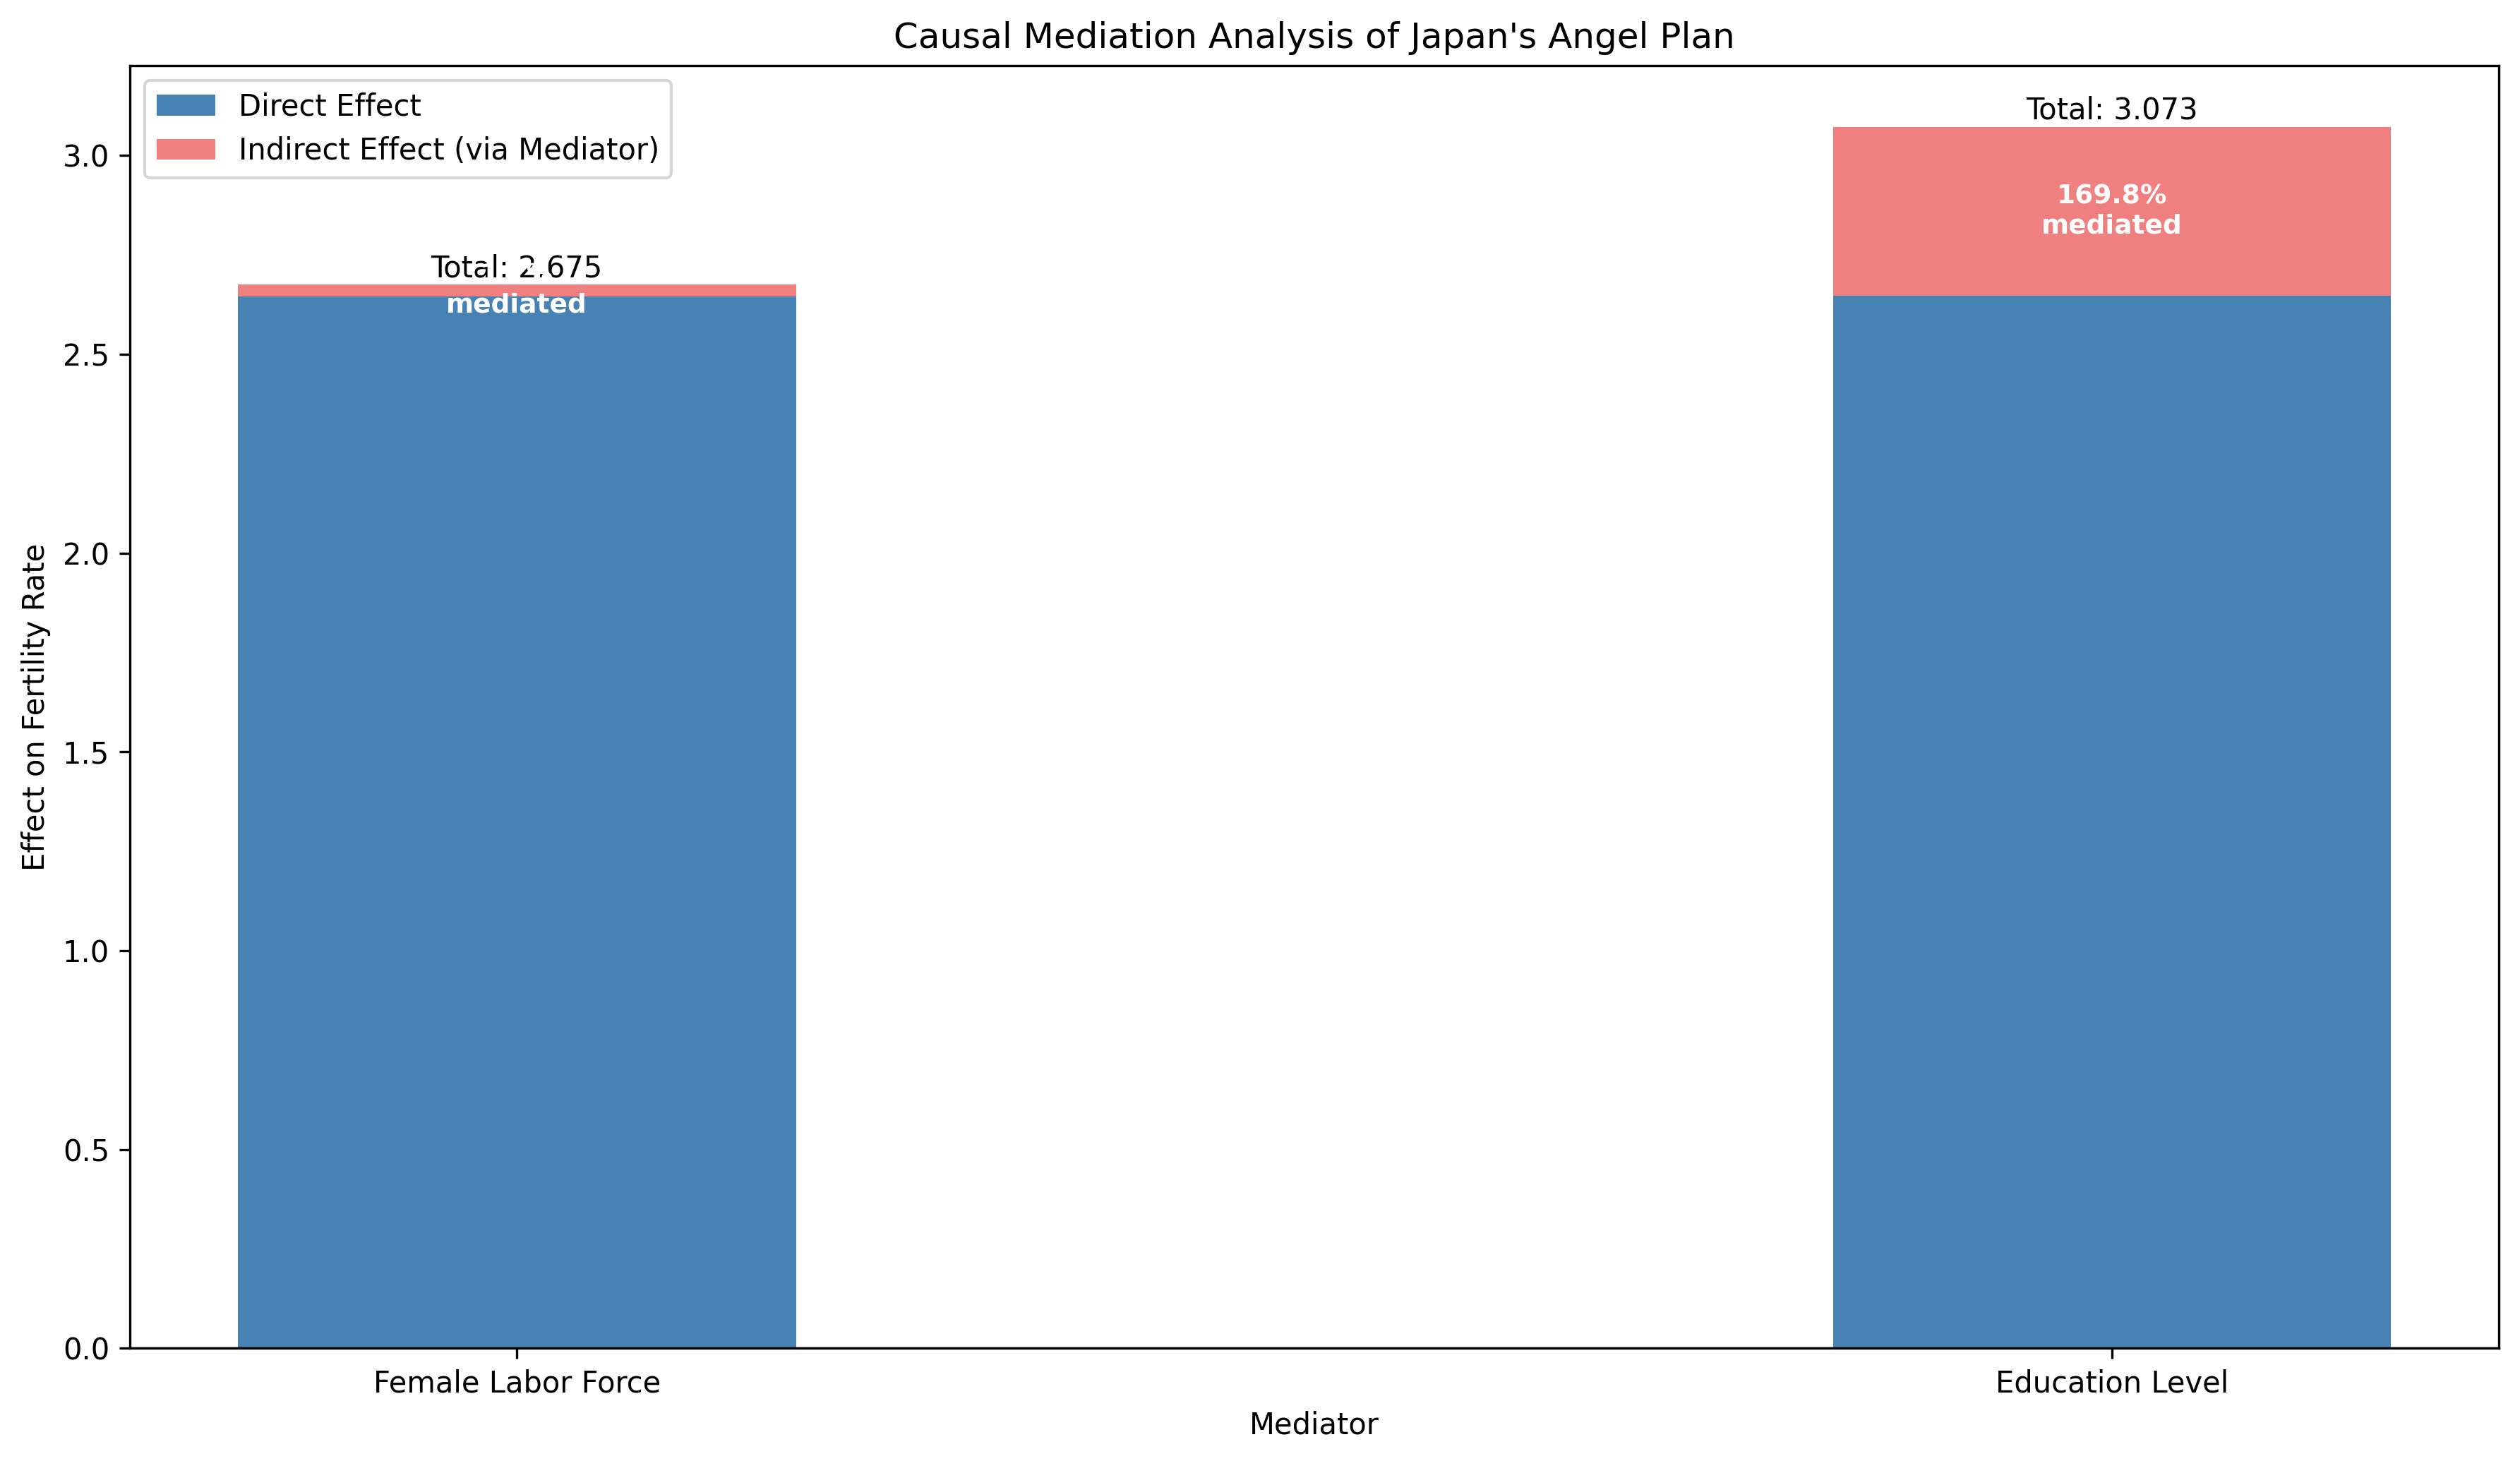

In [53]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Prepare data for mediation analysis
mediation_df = merged.copy()
mediation_df['japan_policy'] = ((mediation_df['Country Name'] == 'Japan') & 
                               (mediation_df['Year'] >= 1994)).astype(int)

# Convert necessary columns to numeric
for col in ['Fertility_Rate', 'GDP', 'Labor_Force_Female', 'Post_Secondary_Total']:
    mediation_df[col] = pd.to_numeric(mediation_df[col], errors='coerce')

# Drop missing values
mediation_df = mediation_df.dropna(subset=['Fertility_Rate', 'GDP', 'Labor_Force_Female'])

# Function to perform mediation analysis
def mediation_analysis(data, treatment, mediator, outcome, covariates=None):
    """
    Perform causal mediation analysis
    
    Parameters:
    data: DataFrame with all variables
    treatment: Treatment variable name (string)
    mediator: Mediator variable name (string)
    outcome: Outcome variable name (string)
    covariates: List of covariate names (list of strings)
    
    Returns:
    Dictionary with mediation results
    """
    if covariates is None:
        covariates = []
        
    # Formula for mediator model (effect of treatment on mediator)
    mediator_formula = f"{mediator} ~ {treatment}"
    if covariates:
        mediator_formula += " + " + " + ".join(covariates)
    
    # Formula for outcome model (effect of treatment and mediator on outcome)
    outcome_formula = f"{outcome} ~ {treatment} + {mediator}"
    if covariates:
        outcome_formula += " + " + " + ".join(covariates)
    
    # Formula for direct effect model (effect of treatment on outcome without mediator)
    direct_formula = f"{outcome} ~ {treatment}"
    if covariates:
        direct_formula += " + " + " + ".join(covariates)
    
    # Fit models
    mediator_model = smf.ols(mediator_formula, data=data).fit()
    outcome_model = smf.ols(outcome_formula, data=data).fit()
    direct_model = smf.ols(direct_formula, data=data).fit()
    
    # Extract coefficients
    effect_on_mediator = mediator_model.params[treatment]
    effect_of_mediator = outcome_model.params[mediator]
    
    # Calculate effects
    indirect_effect = effect_on_mediator * effect_of_mediator
    direct_effect = outcome_model.params[treatment]
    total_effect = direct_model.params[treatment]
    
    # Calculate proportion mediated
    prop_mediated = indirect_effect / total_effect if total_effect != 0 else 0
    
    return {
        'effect_on_mediator': effect_on_mediator,
        'effect_of_mediator': effect_of_mediator,
        'indirect_effect': indirect_effect,
        'direct_effect': direct_effect,
        'total_effect': total_effect,
        'proportion_mediated': prop_mediated
    }

# Analyze mediation through female labor force participation
labor_mediation = mediation_analysis(
    data=mediation_df,
    treatment='japan_policy',
    mediator='Labor_Force_Female',
    outcome='Fertility_Rate',
    covariates=['GDP', 'Post_Secondary_Total']
)

# Analyze mediation through education
education_mediation = mediation_analysis(
    data=mediation_df,
    treatment='japan_policy',
    mediator='Post_Secondary_Total',
    outcome='Fertility_Rate',
    covariates=['GDP', 'Labor_Force_Female']
)

# Print results
print("Mediation through Female Labor Force:")
for key, value in labor_mediation.items():
    print(f"{key}: {value:.4f}")
print("\nMediation through Education:")
for key, value in education_mediation.items():
    print(f"{key}: {value:.4f}")

# Visualize mediation results
plt.figure(figsize=(12, 7), dpi=300)

# Data for plotting
mediators = ['Female Labor Force', 'Education Level']
direct_effects = [labor_mediation['direct_effect'], education_mediation['direct_effect']]
indirect_effects = [labor_mediation['indirect_effect'], education_mediation['indirect_effect']]

# Set up bar chart
x = np.arange(len(mediators))
width = 0.35

# Create bars
plt.bar(x, direct_effects, width, label='Direct Effect', color='steelblue')
plt.bar(x, indirect_effects, width, bottom=direct_effects, 
        label='Indirect Effect (via Mediator)', color='lightcoral')

# Add total effect labels
for i in range(len(mediators)):
    total = direct_effects[i] + indirect_effects[i]
    plt.text(i, total + 0.02, f'Total: {total:.3f}', ha='center')
    
    # Add proportion mediated
    if i == 0:
        prop = labor_mediation['proportion_mediated'] * 100
    else:
        prop = education_mediation['proportion_mediated'] * 100
    plt.text(i, direct_effects[i] + indirect_effects[i]/2, 
             f'{abs(prop):.1f}%\nmediated', ha='center', va='center',
             fontsize=9, color='white', fontweight='bold')

# Customize chart
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
plt.xlabel('Mediator')
plt.ylabel('Effect on Fertility Rate')
plt.title('Causal Mediation Analysis of Japan\'s Angel Plan')
plt.xticks(x, mediators)
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

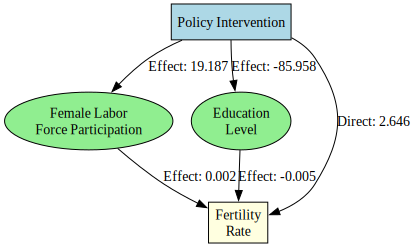

In [54]:
# Create causal pathway visualization
from graphviz import Digraph

mediation_graph = Digraph(name="Mediation Pathways", format="png", engine="dot")

# Add nodes
mediation_graph.node("Policy", "Policy Intervention", shape="box", style="filled", fillcolor="lightblue")
mediation_graph.node("Labor", "Female Labor\nForce Participation", shape="oval", style="filled", fillcolor="lightgreen")
mediation_graph.node("Education", "Education\nLevel", shape="oval", style="filled", fillcolor="lightgreen")
mediation_graph.node("Fertility", "Fertility\nRate", shape="box", style="filled", fillcolor="lightyellow")

# Add edges with effect strengths
mediation_graph.edge("Policy", "Labor", 
                   label=f"Effect: {labor_mediation['effect_on_mediator']:.3f}")
mediation_graph.edge("Labor", "Fertility", 
                   label=f"Effect: {labor_mediation['effect_of_mediator']:.3f}")
mediation_graph.edge("Policy", "Education", 
                   label=f"Effect: {education_mediation['effect_on_mediator']:.3f}")
mediation_graph.edge("Education", "Fertility", 
                   label=f"Effect: {education_mediation['effect_of_mediator']:.3f}")
mediation_graph.edge("Policy", "Fertility", 
                   label=f"Direct: {direct_effects[0]:.3f}")

# Render the graph
mediation_graph